In [1]:
import os
import yaml
import json

os.chdir('/home/ray/DeepMSN/')

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from datasets.topic_datasets import TopicDataset
# from models.deepflybrain import DeepFlyBrain

device = torch.device(f'cuda:4')
print(f"Using {device} device")

Using cuda:4 device


In [3]:
with open('configs/config_dfb-furlanis.yaml', 'r') as f:
    config = yaml.safe_load(f)

checkpoint_path = config.get('train').get('checkpoint').get('path')
checkpoint_path

'checkpoints/dfb_furlanis_2025-05-30_03-10-08'

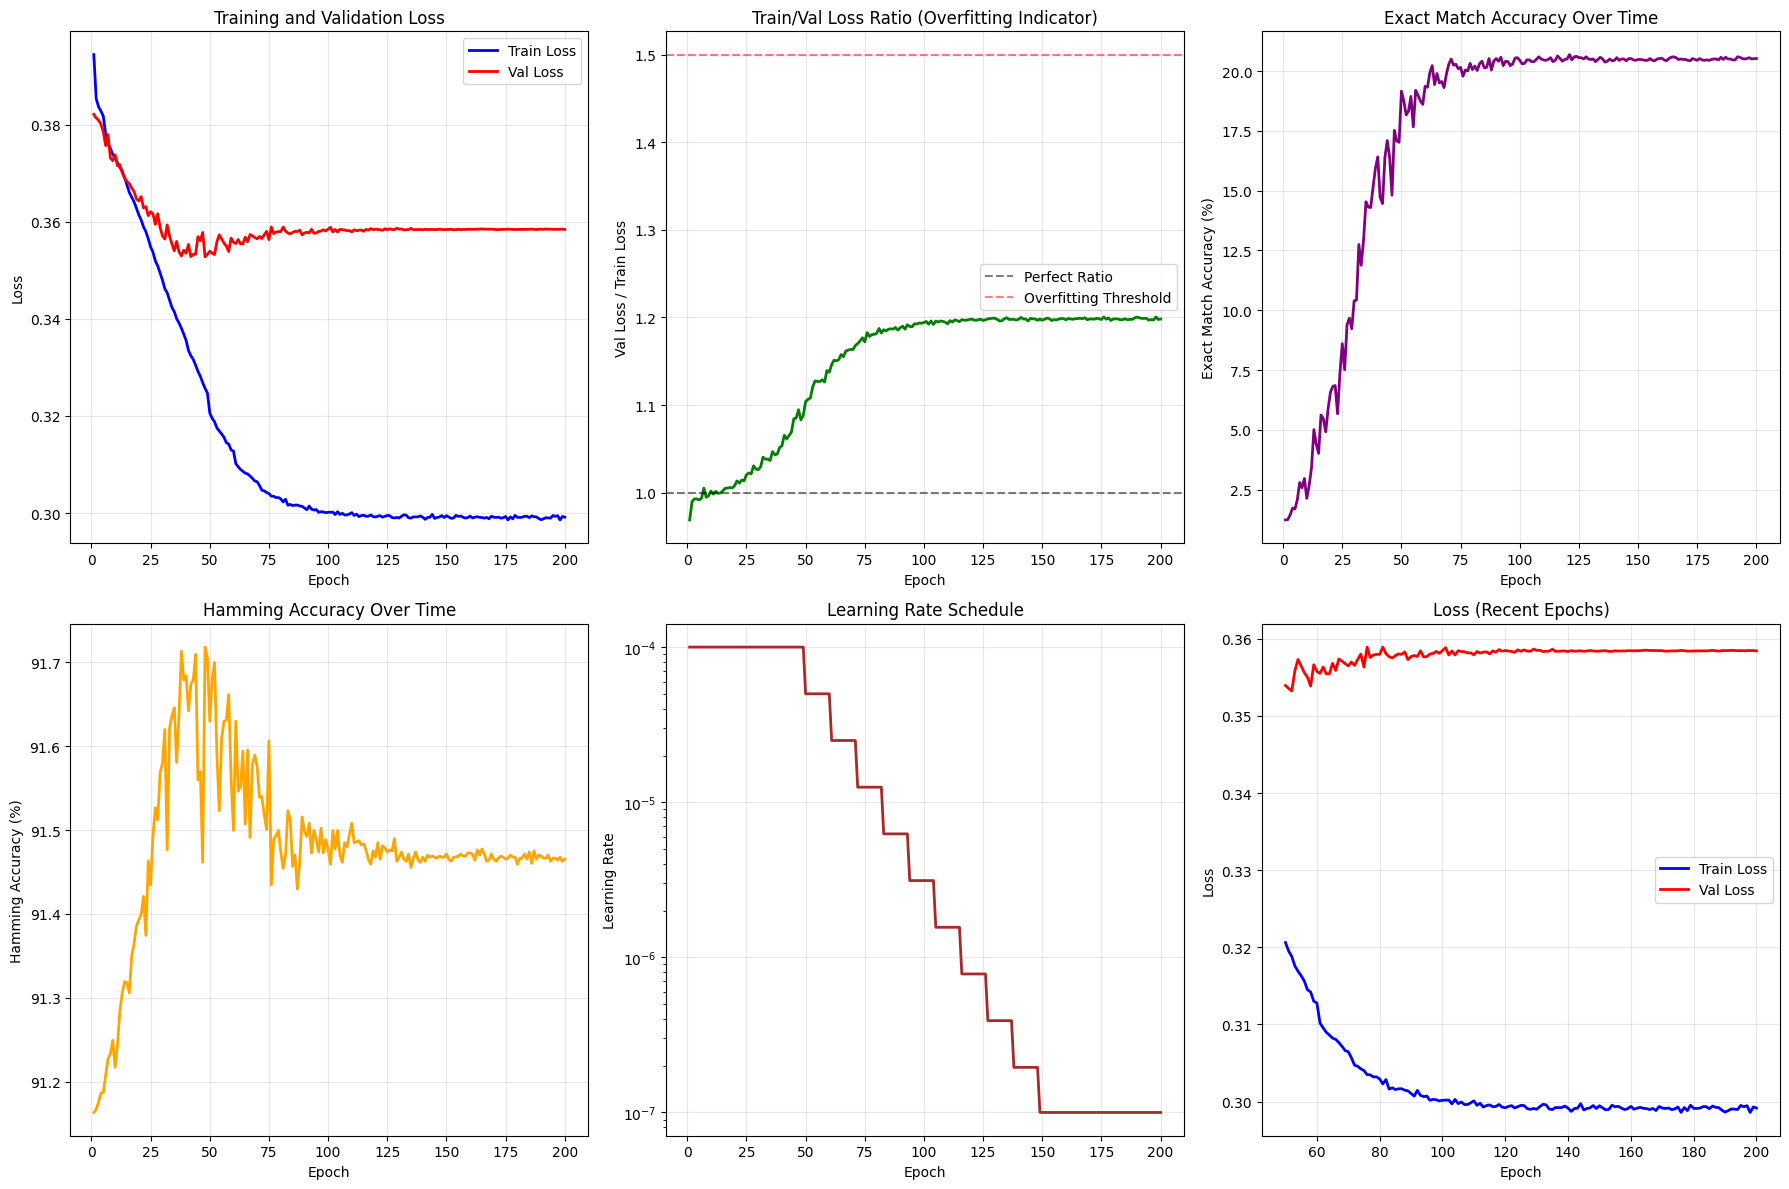

Training Summary:
Initial Train Loss: 0.394427
Final Train Loss: 0.299161
Initial Val Loss: 0.382121
Final Val Loss: 0.358427
Best Val Loss: 0.352775 (Epoch 48)
Best Exact Match Acc: 0.2069 (Epoch 121)
Best Hamming Acc: 0.9172 (Epoch 48)
Final Train/Val Ratio: 1.198


In [4]:
# Add this cell to your notebook to plot training curves

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the training log
training_df = pd.read_csv(f'{checkpoint_path}/training_log.csv')

# Create comprehensive training plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training and Validation Loss
axes[0, 0].plot(training_df['epoch'], training_df['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(training_df['epoch'], training_df['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Train/Val Loss Ratio (Overfitting indicator)
axes[0, 1].plot(training_df['epoch'], training_df['train_val_ratio'], 'g-', linewidth=2)
axes[0, 1].axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Perfect Ratio')
axes[0, 1].axhline(y=1.5, color='r', linestyle='--', alpha=0.5, label='Overfitting Threshold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Val Loss / Train Loss')
axes[0, 1].set_title('Train/Val Loss Ratio (Overfitting Indicator)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Exact Match Accuracy
axes[0, 2].plot(training_df['epoch'], training_df['exact_match_acc'] * 100, 'purple', linewidth=2)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Exact Match Accuracy (%)')
axes[0, 2].set_title('Exact Match Accuracy Over Time')
axes[0, 2].grid(True, alpha=0.3)

# 4. Hamming Accuracy
axes[1, 0].plot(training_df['epoch'], training_df['hamming_acc'] * 100, 'orange', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Hamming Accuracy (%)')
axes[1, 0].set_title('Hamming Accuracy Over Time')
axes[1, 0].grid(True, alpha=0.3)

# 5. Learning Rate Schedule
axes[1, 1].plot(training_df['epoch'], training_df['learning_rate'], 'brown', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

# 6. Loss Comparison (zoomed view of recent epochs)
recent_epochs = training_df['epoch'] >= 50  # Show last part of training
axes[1, 2].plot(training_df[recent_epochs]['epoch'], 
                training_df[recent_epochs]['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[1, 2].plot(training_df[recent_epochs]['epoch'], 
                training_df[recent_epochs]['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].set_title('Loss (Recent Epochs)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Training Summary:")
print(f"Initial Train Loss: {training_df['train_loss'].iloc[0]:.6f}")
print(f"Final Train Loss: {training_df['train_loss'].iloc[-1]:.6f}")
print(f"Initial Val Loss: {training_df['val_loss'].iloc[0]:.6f}")
print(f"Final Val Loss: {training_df['val_loss'].iloc[-1]:.6f}")
print(f"Best Val Loss: {training_df['val_loss'].min():.6f} (Epoch {training_df.loc[training_df['val_loss'].idxmin(), 'epoch']})")
print(f"Best Exact Match Acc: {training_df['exact_match_acc'].max():.4f} (Epoch {training_df.loc[training_df['exact_match_acc'].idxmax(), 'epoch']})")
print(f"Best Hamming Acc: {training_df['hamming_acc'].max():.4f} (Epoch {training_df.loc[training_df['hamming_acc'].idxmax(), 'epoch']})")
print(f"Final Train/Val Ratio: {training_df['train_val_ratio'].iloc[-1]:.3f}")

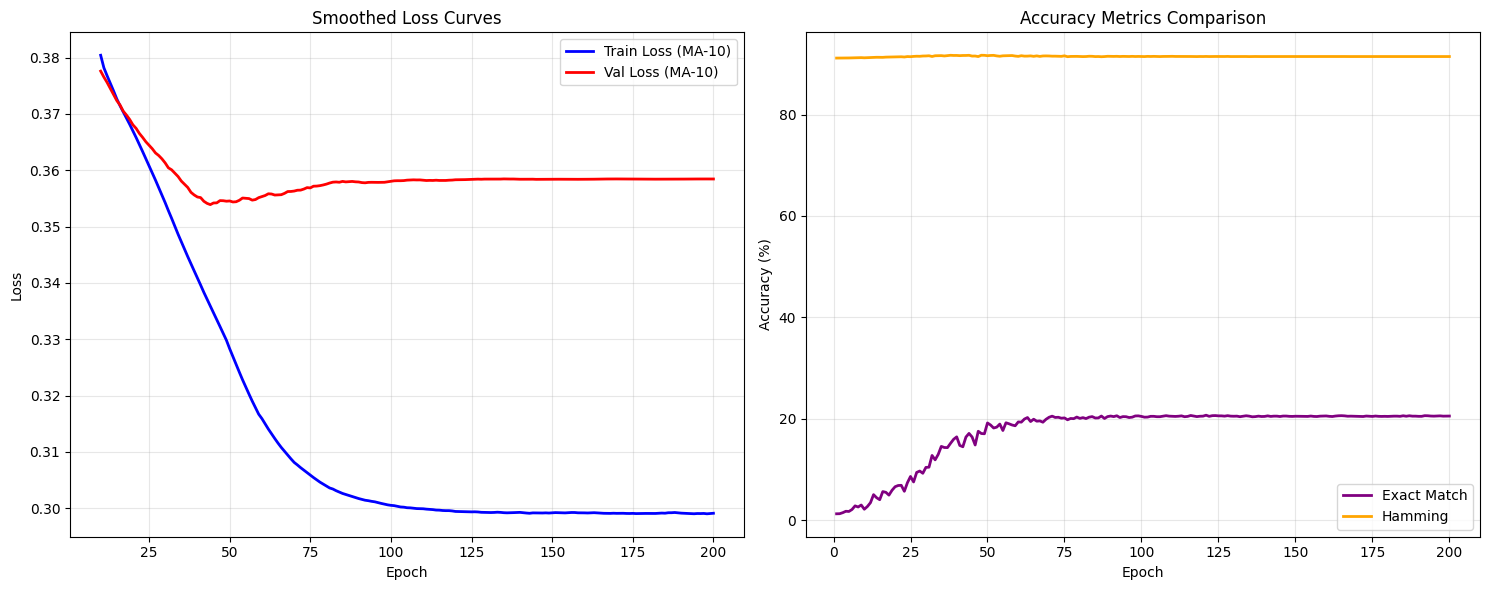

In [5]:
# Additional analysis plots

# Plot 1: Loss improvement over time
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Moving average to smooth curves
window = 10
train_loss_smooth = training_df['train_loss'].rolling(window=window).mean()
val_loss_smooth = training_df['val_loss'].rolling(window=window).mean()

axes[0].plot(training_df['epoch'], train_loss_smooth, 'b-', label=f'Train Loss (MA-{window})', linewidth=2)
axes[0].plot(training_df['epoch'], val_loss_smooth, 'r-', label=f'Val Loss (MA-{window})', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Smoothed Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
axes[1].plot(training_df['epoch'], training_df['exact_match_acc'] * 100, 
             'purple', label='Exact Match', linewidth=2)
axes[1].plot(training_df['epoch'], training_df['hamming_acc'] * 100, 
             'orange', label='Hamming', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy Metrics Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

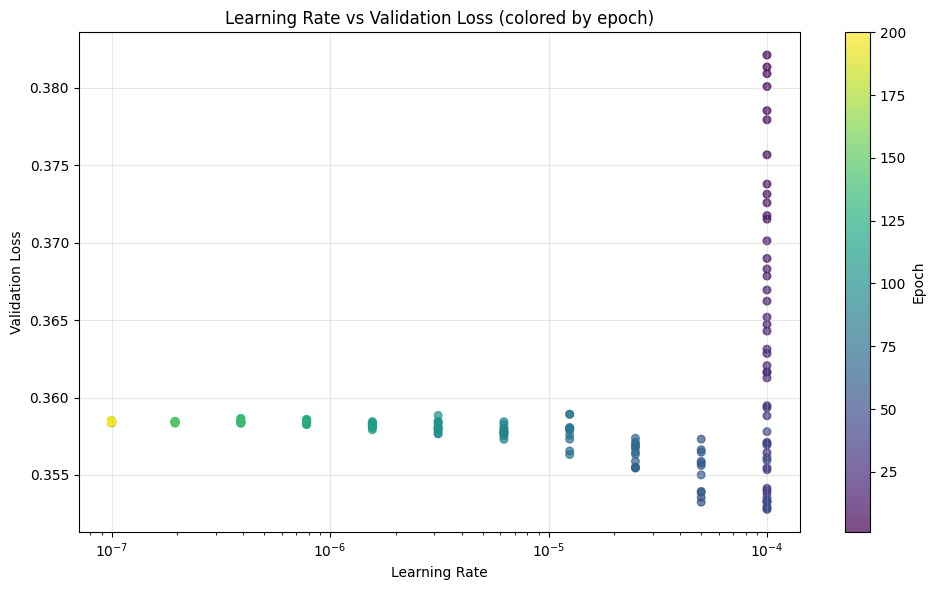

In [6]:
# Learning rate vs loss correlation
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create scatter plot with color gradient
scatter = ax.scatter(training_df['learning_rate'], training_df['val_loss'], 
                    c=training_df['epoch'], cmap='viridis', alpha=0.7, s=30)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Validation Loss')
ax.set_xscale('log')
ax.set_title('Learning Rate vs Validation Loss (colored by epoch)')
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Epoch')

plt.tight_layout()
plt.show()

In [ ]:
# # Training phases analysis
# print("Training Phases Analysis:")
# print("=" * 50)

# # Phase 1: Initial training (epochs 1-50)
# phase1 = training_df[training_df['epoch'] <= 50]
# print(f"Phase 1 (Epochs 1-50):")
# print(f"  Loss reduction: {phase1['train_loss'].iloc[0]:.4f} → {phase1['train_loss'].iloc[-1]:.4f}")
# print(f"  Val loss reduction: {phase1['val_loss'].iloc[0]:.4f} → {phase1['val_loss'].iloc[-1]:.4f}")
# print(f"  Accuracy improvement: {phase1['exact_match_acc'].iloc[0]:.4f} → {phase1['exact_match_acc'].iloc[-1]:.4f}")

# # Phase 2: Middle training (epochs 51-200)
# phase2 = training_df[(training_df['epoch'] > 50) & (training_df['epoch'] <= 200)]
# print(f"\nPhase 2 (Epochs 51-200):")
# print(f"  Loss reduction: {phase2['train_loss'].iloc[0]:.4f} → {phase2['train_loss'].iloc[-1]:.4f}")
# print(f"  Val loss reduction: {phase2['val_loss'].iloc[0]:.4f} → {phase2['val_loss'].iloc[-1]:.4f}")
# print(f"  Best accuracy: {phase2['exact_match_acc'].max():.4f}")

# # Phase 3: Fine-tuning (epochs 201-300)
# phase3 = training_df[training_df['epoch'] > 200]
# print(f"\nPhase 3 (Epochs 201-300):")
# print(f"  Loss reduction: {phase3['train_loss'].iloc[0]:.4f} → {phase3['train_loss'].iloc[-1]:.4f}")
# print(f"  Val loss reduction: {phase3['val_loss'].iloc[0]:.4f} → {phase3['val_loss'].iloc[-1]:.4f}")
# print(f"  Best accuracy: {phase3['exact_match_acc'].max():.4f}")

# # Identify potential overfitting
# overfitting_epochs = training_df[training_df['train_val_ratio'] > 1.5]
# if len(overfitting_epochs) > 0:
#     print(f"\nPotential overfitting detected in {len(overfitting_epochs)} epochs:")
#     print(f"  First occurrence: Epoch {overfitting_epochs['epoch'].iloc[0]}")
#     print(f"  Worst ratio: {overfitting_epochs['train_val_ratio'].max():.3f} at epoch {overfitting_epochs.loc[overfitting_epochs['train_val_ratio'].idxmax(), 'epoch']}")
# else:
#     print(f"\nNo significant overfitting detected (all ratios < 1.5)")

In [7]:
# Determine model used
model_arch = config.get('train').get('model')

if model_arch == 'DeepMSN':
    from models.deepmsn import DeepMSN
    ModelClass = DeepMSN
elif model_arch == 'DeepFlyBrain':
    from models.deepflybrain import DeepFlyBrain
    ModelClass = DeepFlyBrain

In [8]:
# Load model from checkpoint
state_dict = torch.load(f'{checkpoint_path}/final_model.pth')

model = ModelClass(config=config).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [9]:
# Resume dataset and dataloaders from saved indices
batch_size = 64
dataset = TopicDataset(config=config['dataset'])

with open(f'{checkpoint_path}/test_indices.txt', 'r') as f:
    test_indices = [int(line.strip()) for line in f.readlines()]
test_dataset = torch.utils.data.Subset(dataset, test_indices)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)  # Entire dataset
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)  # Test dataset

In [10]:
# Loss function
# Label smoothing loss to prevent overconfident predictions
class LabelSmoothingBCELoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.bce = nn.BCEWithLogitsLoss()
    
    def forward(self, pred, target):
        # Apply label smoothing: y_smooth = y * (1-α) + α/2
        target_smooth = target * (1 - self.smoothing) + 0.5 * self.smoothing
        return self.bce(pred, target_smooth)

loss_fn = LabelSmoothingBCELoss(smoothing=0.1)

In [11]:
# Evaluate model on entire dataset
model.eval()

loss, correct = 0, 0
all_test_probs = []
all_test_targets = []

with torch.no_grad():
    for batch in dataloader:
        X, y = batch['sequence'], batch['label']
        X, y = X.to(device), y.to(device)
        y = y.float()
        
        pred = model(X)
        prob = torch.sigmoid(pred)
        loss += loss_fn(pred, y).item()
        
        all_test_probs.append(prob)
        all_test_targets.append(y)
        
        # Exact match accuracy
        pred_binary = (prob > 0.5).float()
        exact_match = ((pred_binary == y).sum(dim=1) == y.shape[1]).float().sum().item()
        correct += exact_match

all_test_probs = torch.cat(all_test_probs, dim=0)
all_test_targets = torch.cat(all_test_targets, dim=0)

loss /= len(dataloader)
exact_acc = correct / len(dataset)

pred_binary = (all_test_probs > 0.5).float()
hamming_acc = (pred_binary == all_test_targets).float().mean().item()

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix

In [13]:
# Convert PyTorch tensors to numpy for sklearn
y_pred_np = all_test_probs.cpu().numpy()
y_test_np = all_test_targets.cpu().numpy()

print("Prediction min/max:", np.min(y_pred_np), np.max(y_pred_np))
print("Prediction shape:", y_pred_np.shape)
print("Target shape:", y_test_np.shape)

Prediction min/max: 0.00082325155 0.999863
Prediction shape: (36190, 15)
Target shape: (36190, 15)


In [14]:
# Class distribution analysis
print("\nClass distribution (fraction of positives per topic):")
class_means = np.mean(y_test_np, axis=0)
for i, mean_val in enumerate(class_means):
    print(f"Topic {i}: {mean_val:.4f}")


Class distribution (fraction of positives per topic):
Topic 0: 0.0865
Topic 1: 0.0902
Topic 2: 0.0964
Topic 3: 0.0912
Topic 4: 0.0930
Topic 5: 0.0882
Topic 6: 0.0824
Topic 7: 0.0924
Topic 8: 0.0866
Topic 9: 0.0883
Topic 10: 0.0894
Topic 11: 0.0912
Topic 12: 0.0888
Topic 13: 0.0897
Topic 14: 0.0885


In [15]:
# Confusion matrix for each topic
print("\nConfusion matrices for each topic:")
for i in range(y_test_np.shape[1]):
    print(f"\nTopic {i}:")
    cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i] > 0.5)
    print(cm)


Confusion matrices for each topic:

Topic 0:
[[32667   393]
 [ 1740  1390]]

Topic 1:
[[32648   279]
 [ 1969  1294]]

Topic 2:
[[32476   227]
 [ 1611  1876]]

Topic 3:
[[32285   605]
 [ 1390  1910]]

Topic 4:
[[32703   120]
 [ 1953  1414]]

Topic 5:
[[32769   229]
 [ 2310   882]]

Topic 6:
[[32887   322]
 [ 1824  1157]]

Topic 7:
[[32676   170]
 [ 2220  1124]]

Topic 8:
[[32925   132]
 [ 2507   626]]

Topic 9:
[[32655   339]
 [ 2154  1042]]

Topic 10:
[[32778   175]
 [  765  2472]]

Topic 11:
[[32556   333]
 [ 1535  1766]]

Topic 12:
[[32809   169]
 [ 2324   888]]

Topic 13:
[[32811   132]
 [ 2522   725]]

Topic 14:
[[32682   306]
 [  903  2299]]



Evaluating 15 topics...
Evaluating topic 0
Topic 0 - auROC: 0.9146, auPR: 0.6520, F1: 0.5658


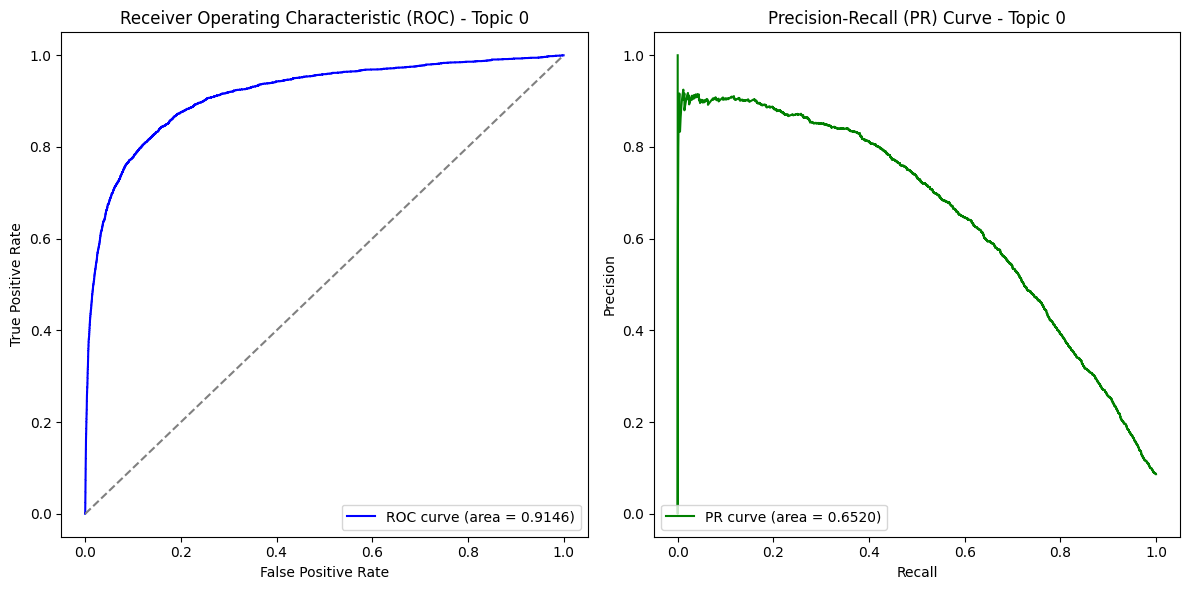

Evaluating topic 1
Topic 1 - auROC: 0.9152, auPR: 0.6682, F1: 0.5352


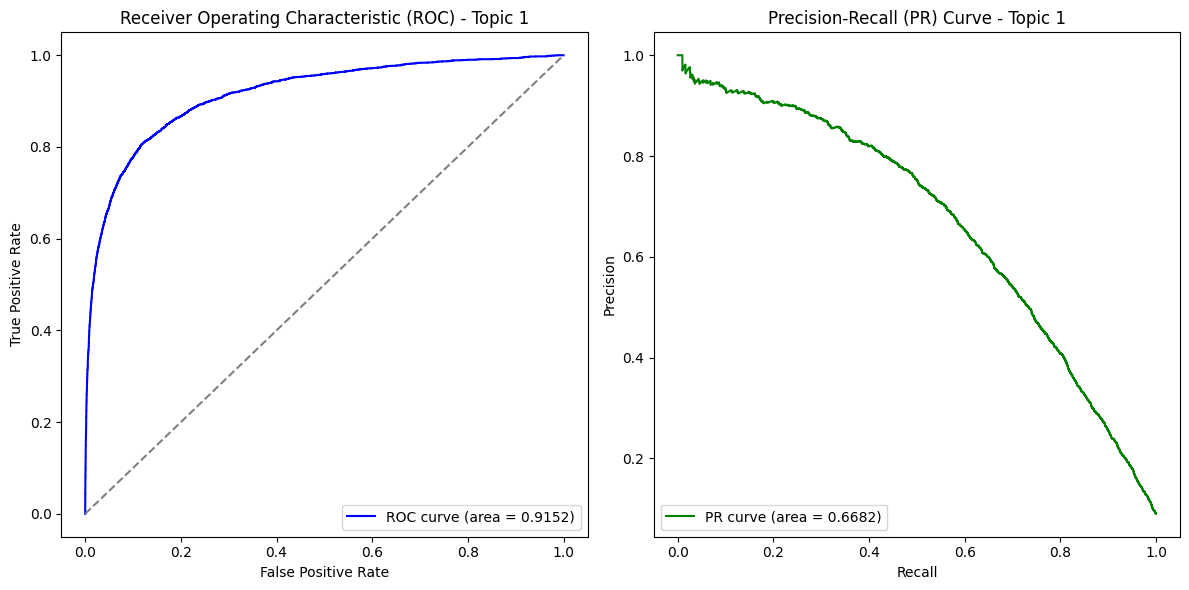

Evaluating topic 2
Topic 2 - auROC: 0.9468, auPR: 0.8001, F1: 0.6712


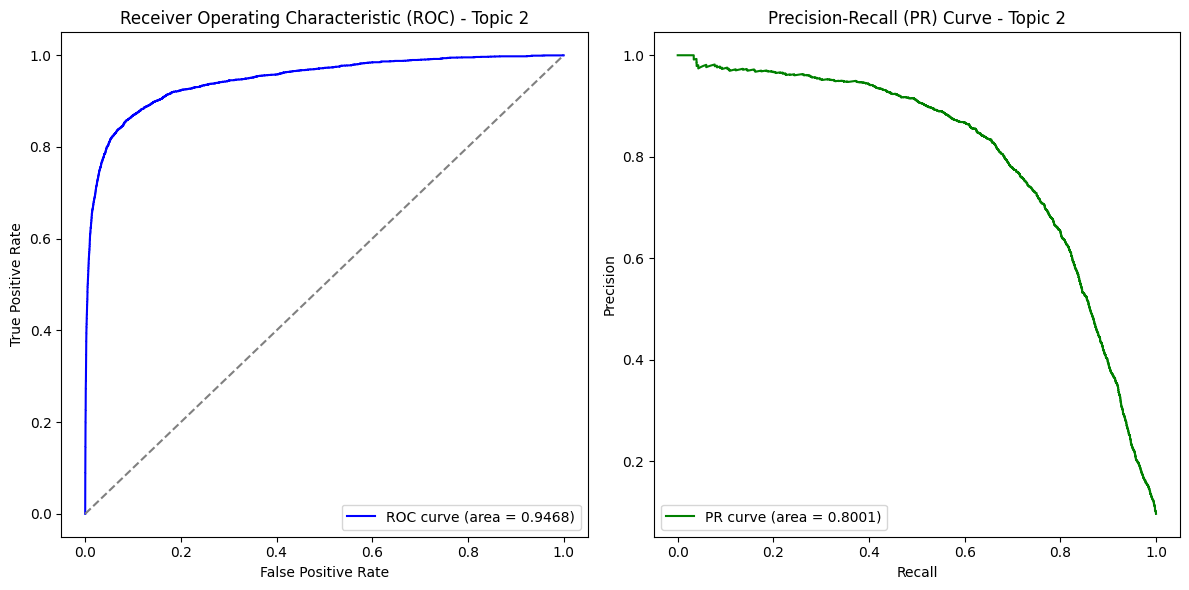

Evaluating topic 3
Topic 3 - auROC: 0.9375, auPR: 0.7325, F1: 0.6569


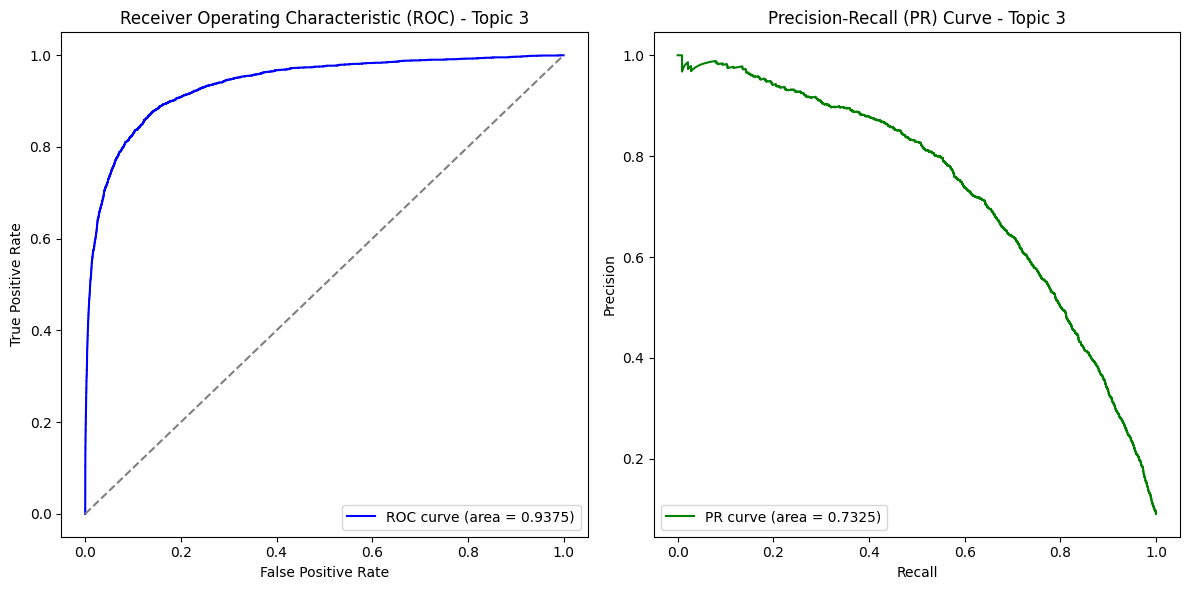

Evaluating topic 4
Topic 4 - auROC: 0.9447, auPR: 0.7843, F1: 0.5770


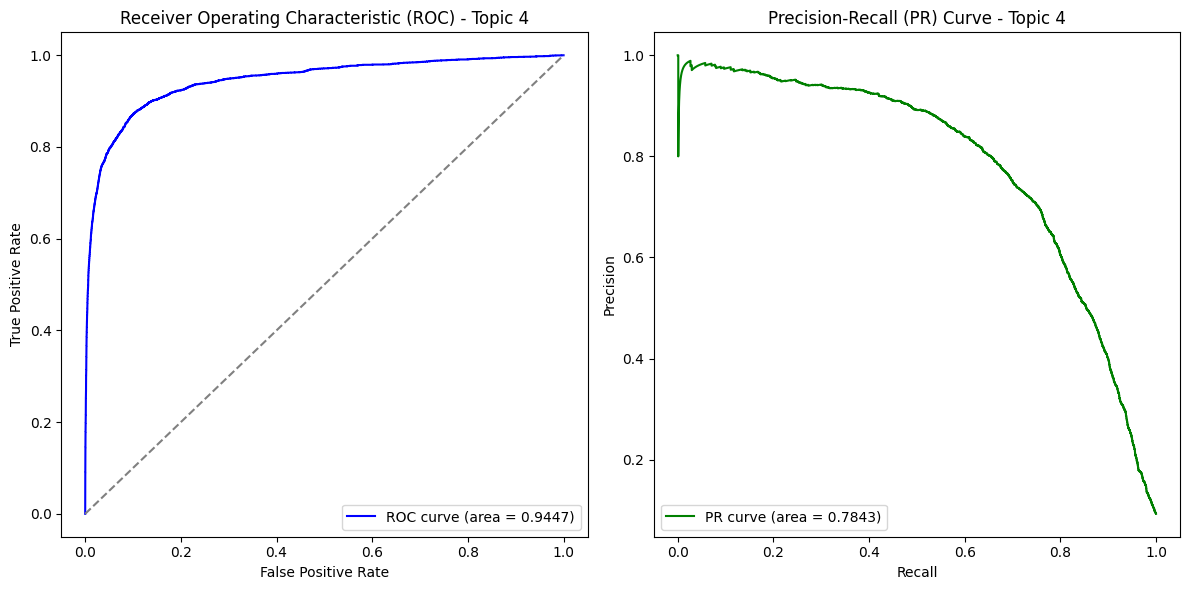

Evaluating topic 5
Topic 5 - auROC: 0.9003, auPR: 0.5916, F1: 0.4099


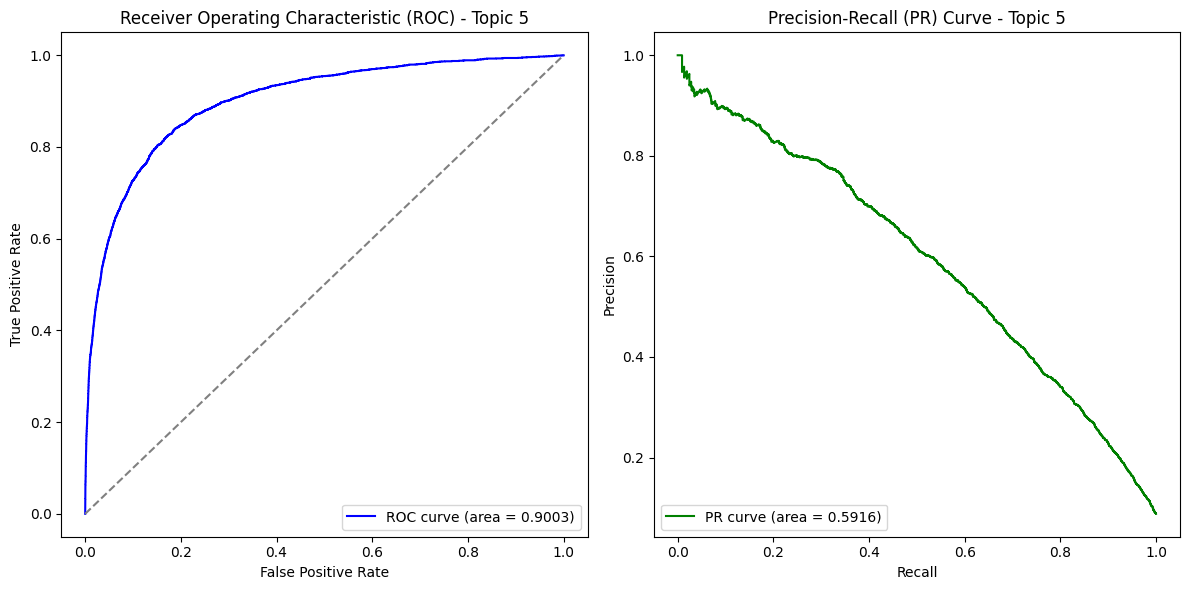

Evaluating topic 6
Topic 6 - auROC: 0.9160, auPR: 0.6487, F1: 0.5188


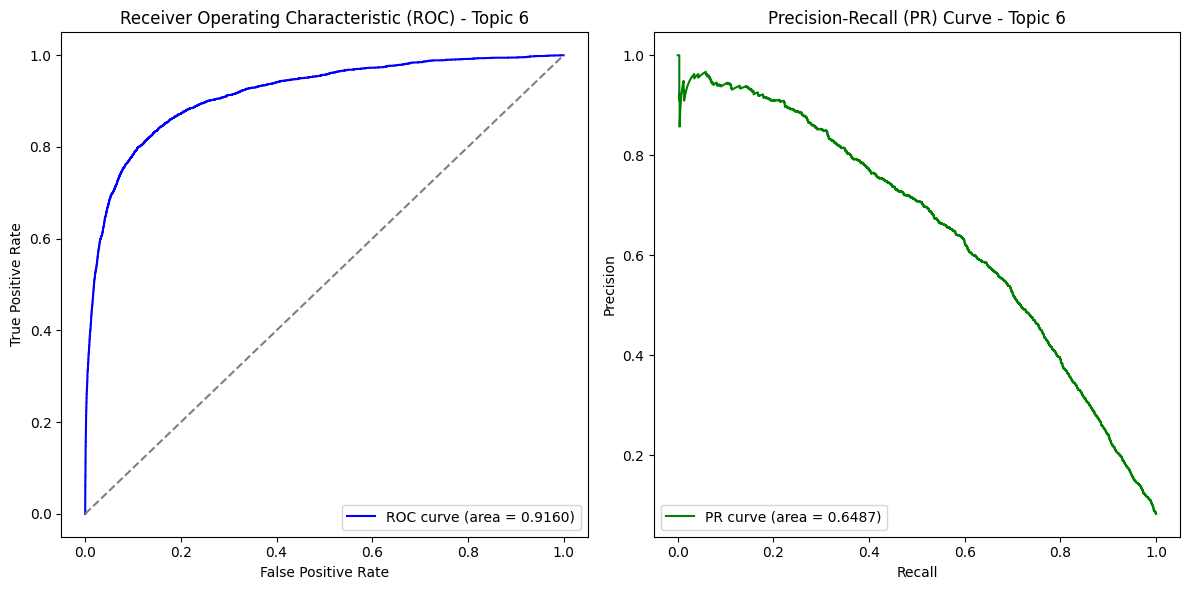

Evaluating topic 7
Topic 7 - auROC: 0.9186, auPR: 0.6847, F1: 0.4847


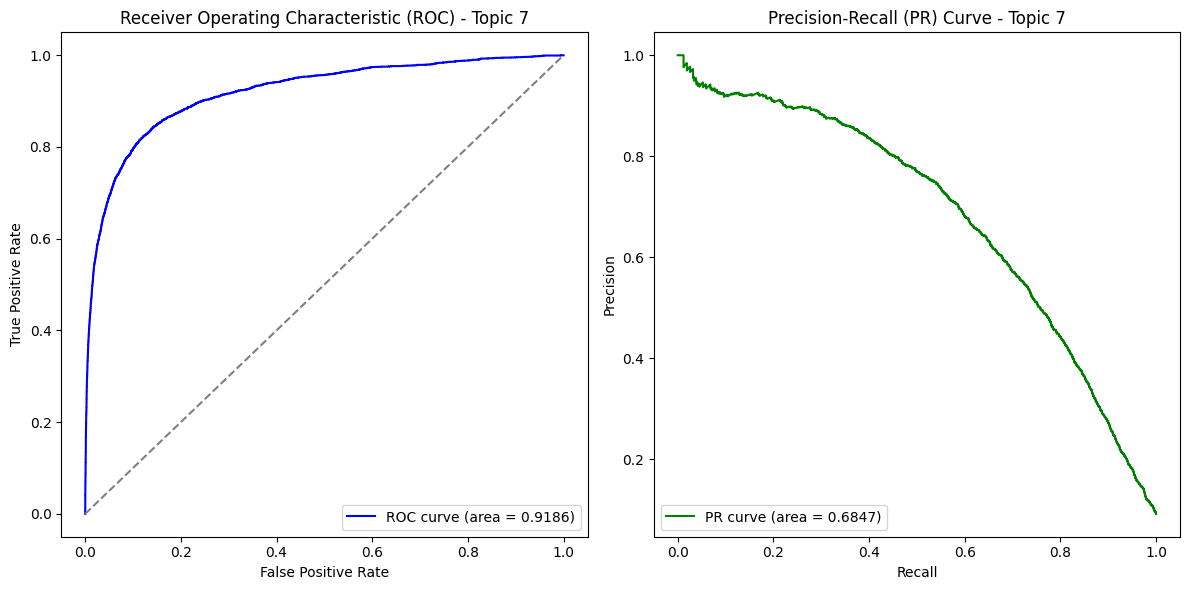

Evaluating topic 8
Topic 8 - auROC: 0.8850, auPR: 0.5639, F1: 0.3218


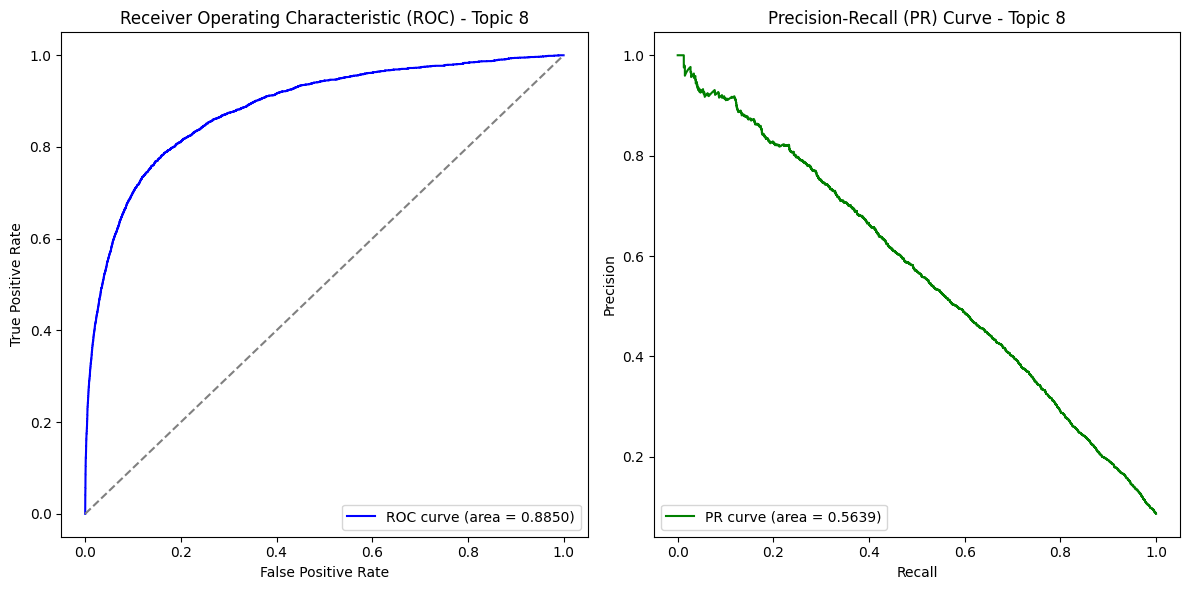

Evaluating topic 9
Topic 9 - auROC: 0.9002, auPR: 0.5898, F1: 0.4553


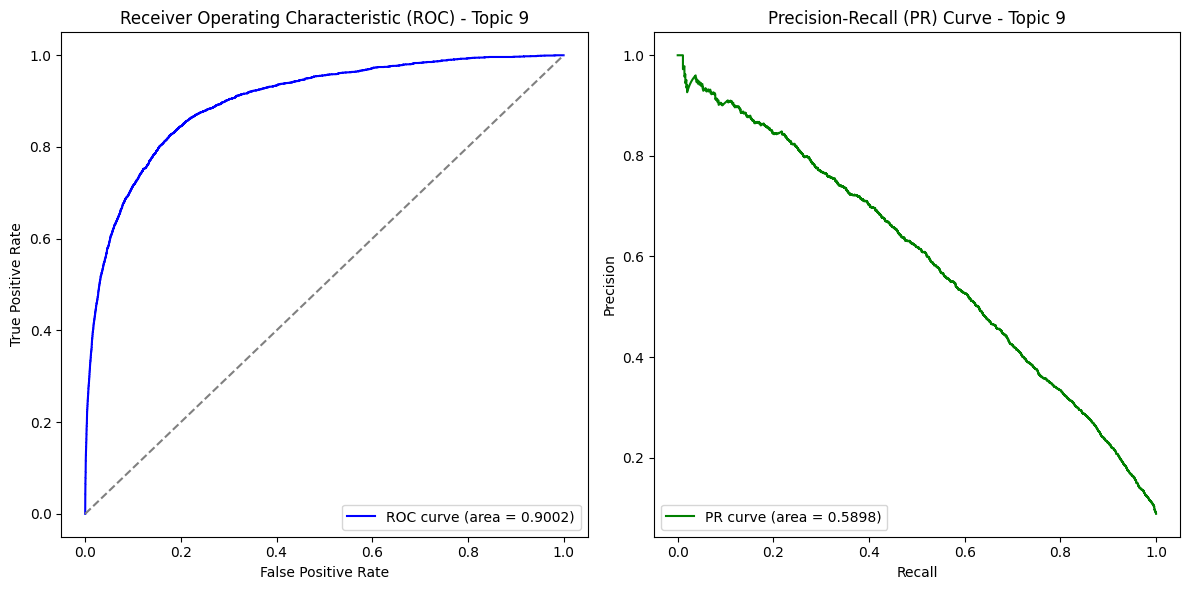

Evaluating topic 10
Topic 10 - auROC: 0.9735, auPR: 0.9022, F1: 0.8402


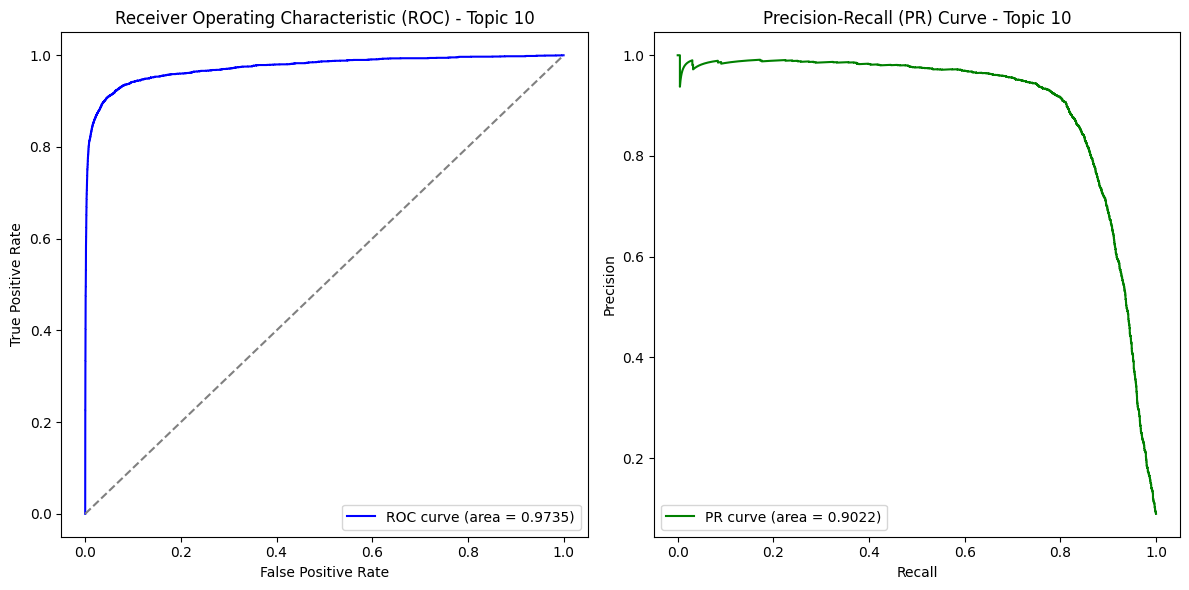

Evaluating topic 11
Topic 11 - auROC: 0.9332, auPR: 0.7558, F1: 0.6541


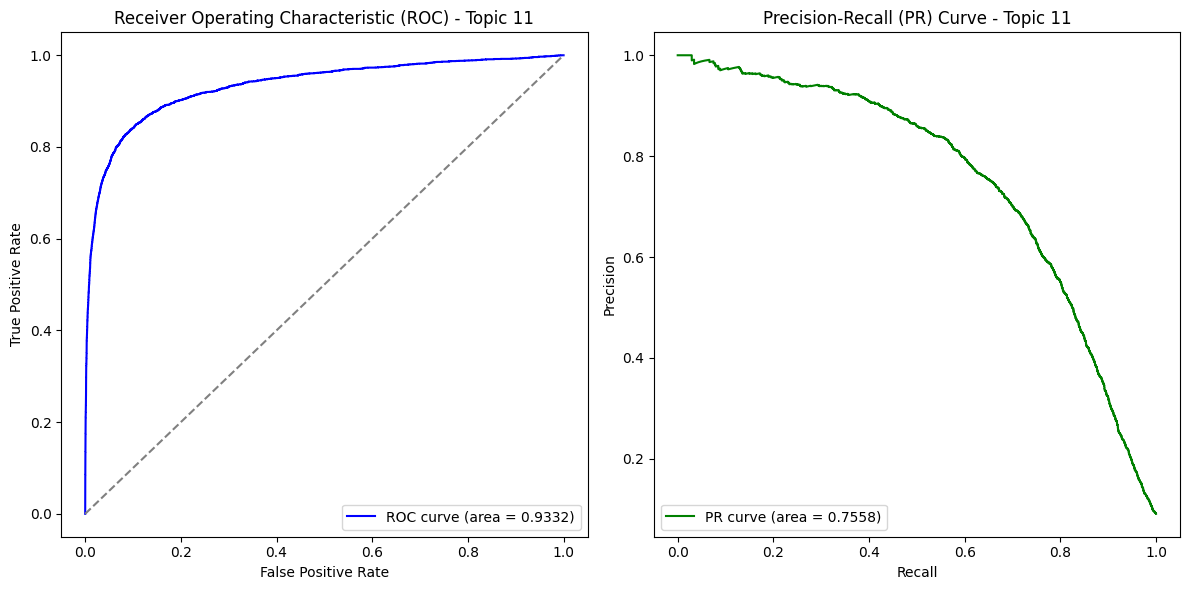

Evaluating topic 12
Topic 12 - auROC: 0.8961, auPR: 0.6159, F1: 0.4160


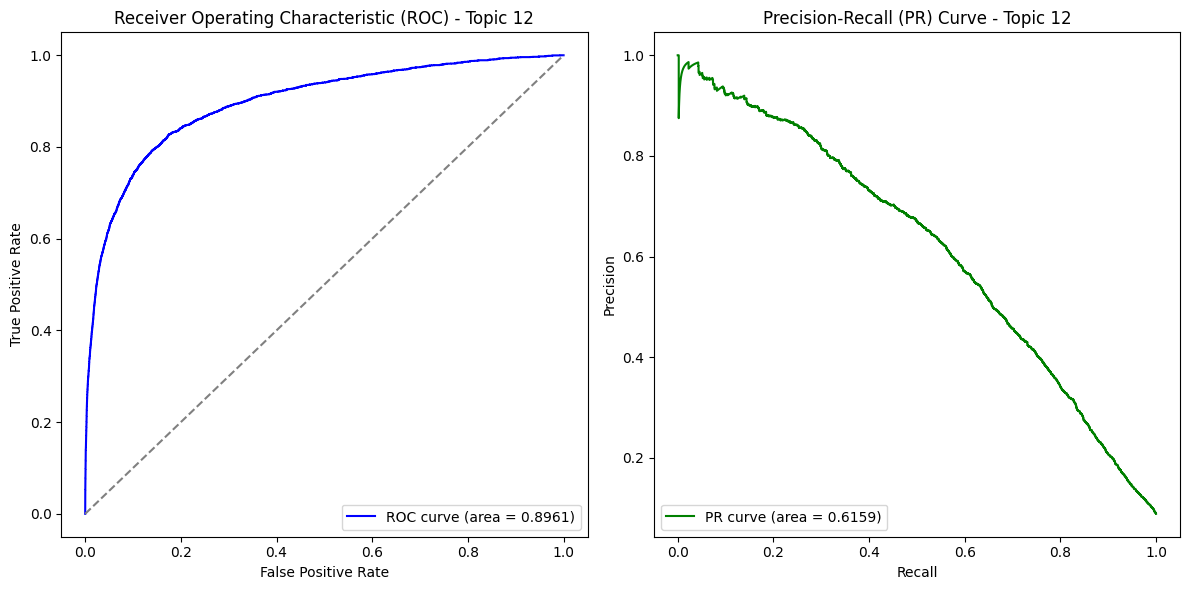

Evaluating topic 13
Topic 13 - auROC: 0.8856, auPR: 0.5753, F1: 0.3533


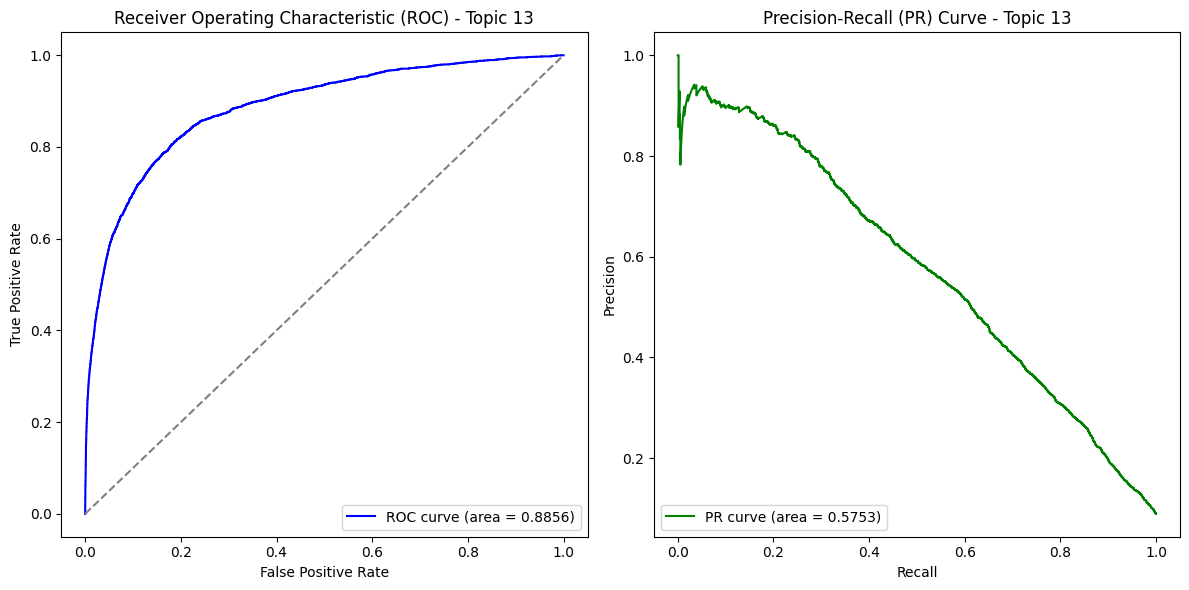

Evaluating topic 14
Topic 14 - auROC: 0.9686, auPR: 0.8677, F1: 0.7918


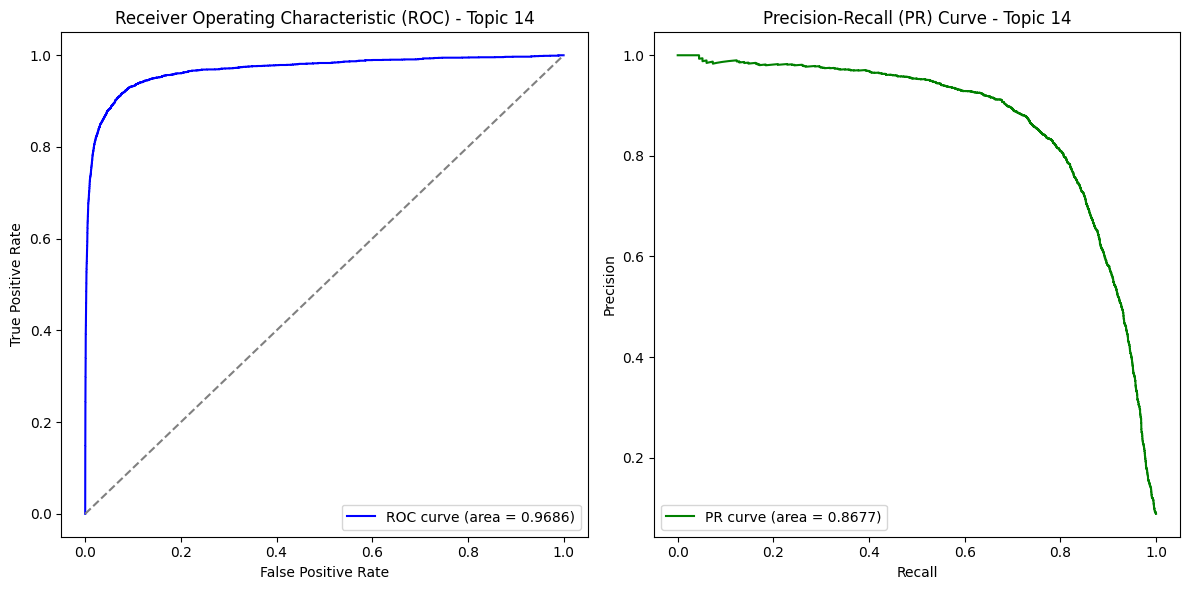

In [16]:
# Evaluate model performance for each topic
num_topics = y_test_np.shape[1]
auroc_values = []
aupr_values = []
f1_scores = []

print(f"\nEvaluating {num_topics} topics...")

for topic_idx in range(num_topics):
    print(f'Evaluating topic {topic_idx}')
    
    # Calculate ROC and PR metrics for the current topic
    fpr, tpr, _ = roc_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    roc_auc = auc(fpr, tpr)
    auroc_values.append(roc_auc)
    
    precision, recall, _ = precision_recall_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    pr_auc = auc(recall, precision)
    aupr_values.append(pr_auc)

    # Binarize predictions for F1 score calculation
    y_pred_bin = (y_pred_np[:, topic_idx] >= 0.5).astype(int)
    f1 = f1_score(y_test_np[:, topic_idx], y_pred_bin)
    f1_scores.append(f1)
    
    print(f'Topic {topic_idx} - auROC: {roc_auc:.4f}, auPR: {pr_auc:.4f}, F1: {f1:.4f}')
    
    # Plot ROC and PR curves for the current topic
    plt.figure(figsize=(12, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - Topic {topic_idx}')
    plt.legend(loc='lower right')
    
    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', label=f'PR curve (area = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall (PR) Curve - Topic {topic_idx}')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

In [17]:
# Summary statistics
print(f"\nSummary Statistics:")
print(f"Mean auROC: {np.mean(auroc_values):.4f} ± {np.std(auroc_values):.4f}")
print(f"Mean auPR: {np.mean(aupr_values):.4f} ± {np.std(aupr_values):.4f}")
print(f"Mean F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Exact Match Accuracy: {exact_acc:.4f}")
print(f"Hamming Accuracy: {hamming_acc:.4f}")


Summary Statistics:
Mean auROC: 0.9224 ± 0.0268
Mean auPR: 0.6955 ± 0.1037
Mean F1: 0.5501 ± 0.1468
Exact Match Accuracy: 0.3904
Hamming Accuracy: 0.9417


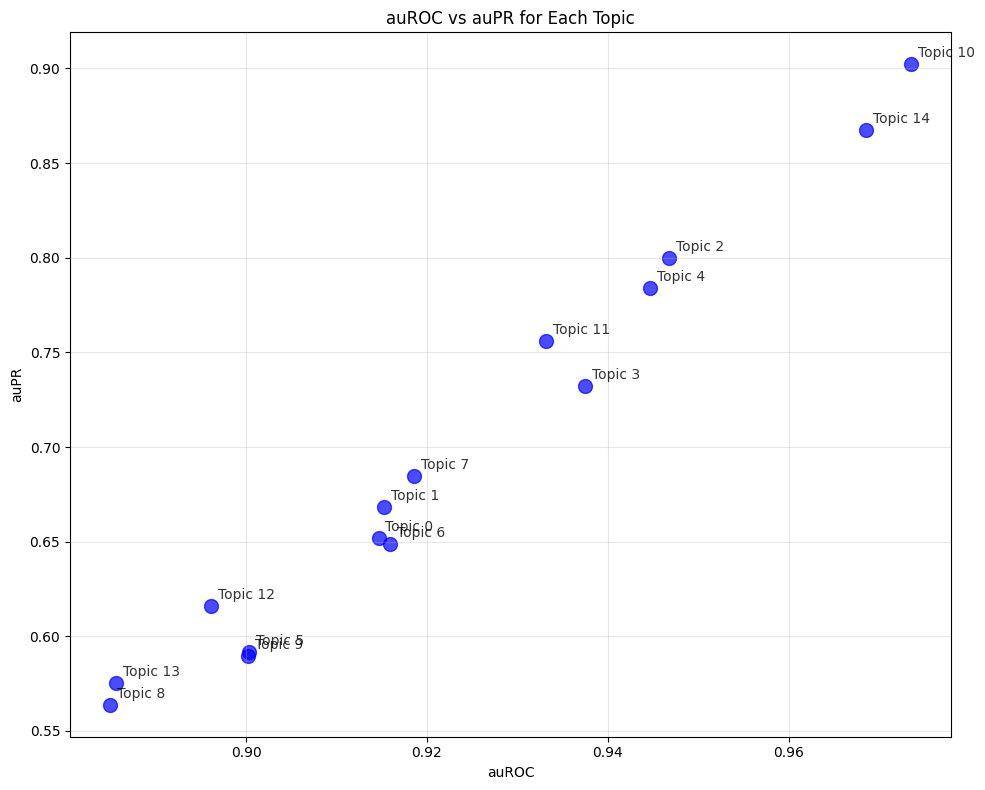

In [18]:
# Scatter plot of auROC vs auPR
plt.figure(figsize=(10, 8))
plt.scatter(auroc_values, aupr_values, color='blue', alpha=0.7, s=100, )
plt.xlabel('auROC')
plt.ylabel('auPR')
plt.title('auROC vs auPR for Each Topic')
plt.grid(True, alpha=0.3)

# Annotate each point with the topic index
for i, (x, y) in enumerate(zip(auroc_values, aupr_values)):
    plt.annotate(f'Topic {i}', (x, y), fontsize=10, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

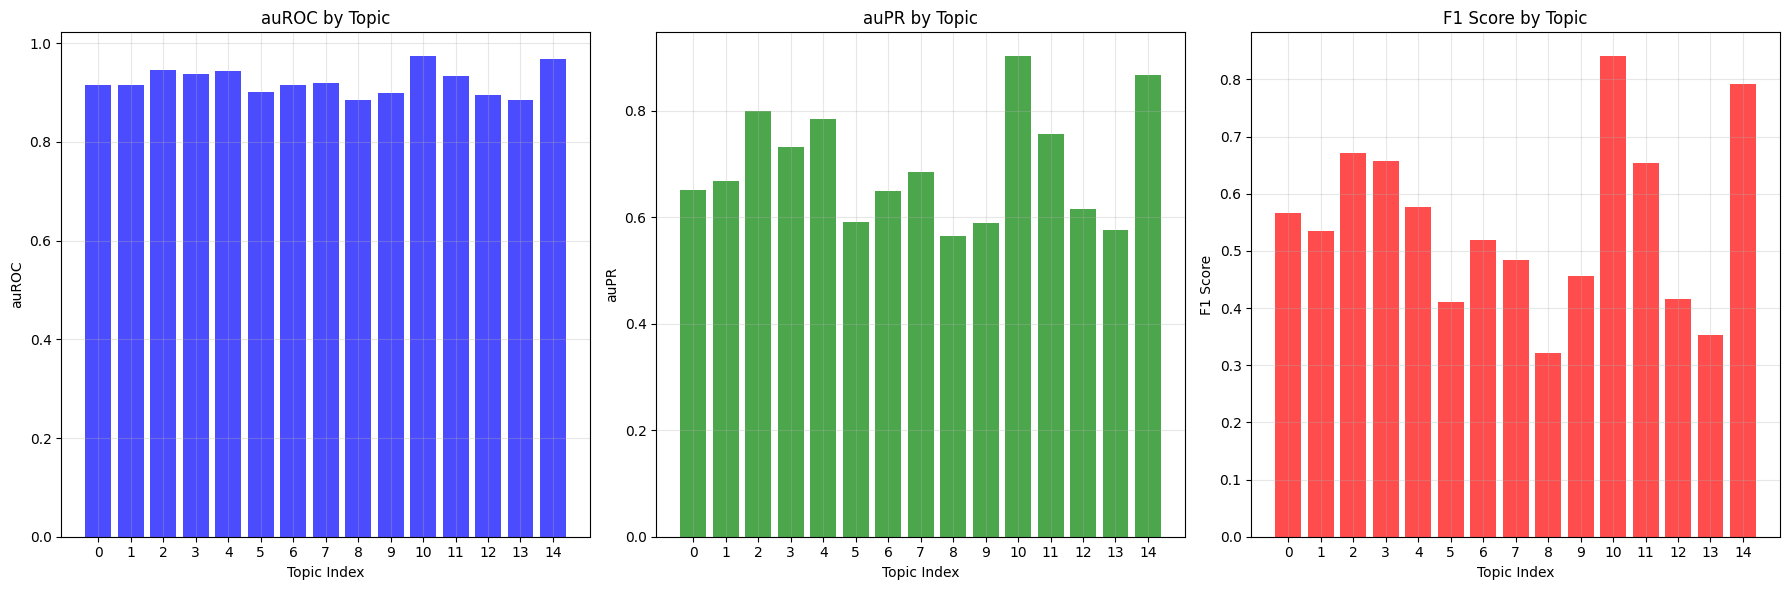

In [19]:
# Bar plots for metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# auROC bar plot
axes[0].bar(range(num_topics), auroc_values, color='blue', alpha=0.7)
axes[0].set_xlabel('Topic Index')
axes[0].set_ylabel('auROC')
axes[0].set_title('auROC by Topic')
axes[0].set_xticks(range(num_topics))
axes[0].grid(True, alpha=0.3)

# auPR bar plot
axes[1].bar(range(num_topics), aupr_values, color='green', alpha=0.7)
axes[1].set_xlabel('Topic Index')
axes[1].set_ylabel('auPR')
axes[1].set_title('auPR by Topic')
axes[1].set_xticks(range(num_topics))
axes[1].grid(True, alpha=0.3)

# F1 bar plot
axes[2].bar(range(num_topics), f1_scores, color='red', alpha=0.7)
axes[2].set_xlabel('Topic Index')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score by Topic')
axes[2].set_xticks(range(num_topics))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

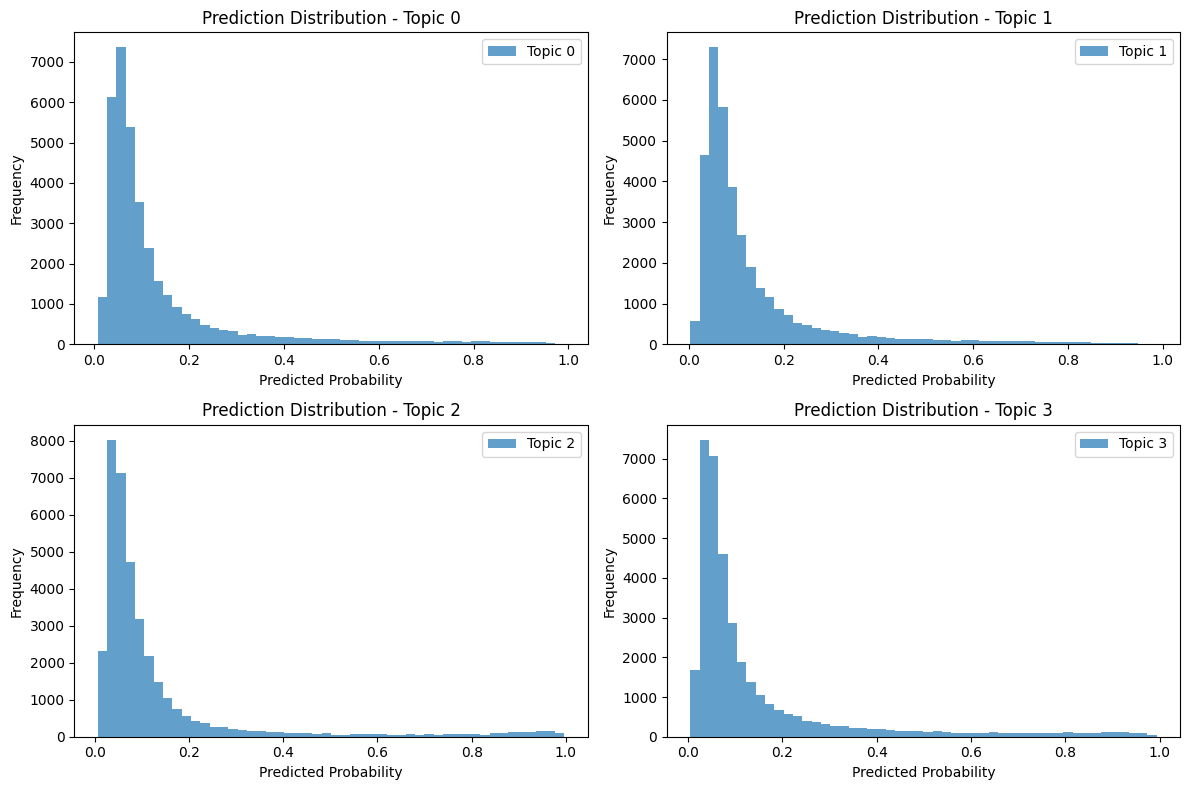


Sample predictions (first 10 samples):
Sample 0:
  Predicted: [0.07080748 0.07084763 0.49547958 0.20088036 0.02497619 0.08007932
 0.11814988 0.02322634 0.06404263 0.15306467 0.0418175  0.12201768
 0.05278023 0.08922417 0.1128687 ]
  Actual:    [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 1:
  Predicted: [0.04237679 0.08588574 0.5260987  0.19338535 0.06984225 0.04361268
 0.05458114 0.04273119 0.05179218 0.06489366 0.06021351 0.28399575
 0.0618517  0.14825141 0.04057607]
  Actual:    [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 2:
  Predicted: [0.12387686 0.42368582 0.03764534 0.03781085 0.07658925 0.11817271
 0.809541   0.05391028 0.07092988 0.04002702 0.06405331 0.04159854
 0.07420634 0.02798997 0.03816591]
  Actual:    [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]

Sample 3:
  Predicted: [0.15254933 0.39957222 0.04764746 0.0674886

In [20]:
# Additional analysis: Prediction distribution
plt.figure(figsize=(12, 8))

# Histogram of predictions for each topic
for i in range(min(4, num_topics)):  # Show first 4 topics
    plt.subplot(2, 2, i+1)
    plt.hist(y_pred_np[:, i], bins=50, alpha=0.7, label=f'Topic {i}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Distribution - Topic {i}')
    plt.legend()

plt.tight_layout()
plt.show()

# Sample predictions vs targets
print("\nSample predictions (first 10 samples):")
for i in range(min(10, y_pred_np.shape[0])):
    print(f"Sample {i}:")
    print(f"  Predicted: {y_pred_np[i]}")
    print(f"  Actual:    {y_test_np[i]}")
    print(f"  Binary:    {(y_pred_np[i] > 0.5).astype(int)}")
    print()

In [21]:
# Evaluate model on entire dataset
model.eval()

loss, correct = 0, 0
all_test_probs = []
all_test_targets = []

with torch.no_grad():
    for batch in test_dataloader:
        X, y = batch['sequence'], batch['label']
        X, y = X.to(device), y.to(device)
        y = y.float()
        
        pred = model(X)
        prob = torch.sigmoid(pred)
        loss += loss_fn(pred, y).item()
        
        all_test_probs.append(prob)
        all_test_targets.append(y)
        
        # Exact match accuracy
        pred_binary = (prob > 0.5).float()
        exact_match = ((pred_binary == y).sum(dim=1) == y.shape[1]).float().sum().item()
        correct += exact_match

all_test_probs = torch.cat(all_test_probs, dim=0)
all_test_targets = torch.cat(all_test_targets, dim=0)

loss /= len(test_dataloader)
exact_acc = correct / len(dataset)

pred_binary = (all_test_probs > 0.5).float()
hamming_acc = (pred_binary == all_test_targets).float().mean().item()

In [22]:
# Convert PyTorch tensors to numpy for sklearn
y_pred_np = all_test_probs.cpu().numpy()
y_test_np = all_test_targets.cpu().numpy()

print("Prediction min/max:", np.min(y_pred_np), np.max(y_pred_np))
print("Prediction shape:", y_pred_np.shape)
print("Target shape:", y_test_np.shape)

Prediction min/max: 0.00082325155 0.999863
Prediction shape: (5429, 15)
Target shape: (5429, 15)


In [23]:
# Class distribution analysis
print("\nClass distribution (fraction of positives per topic):")
class_means = np.mean(y_test_np, axis=0)
for i, mean_val in enumerate(class_means):
    print(f"Topic {i}: {mean_val:.4f}")


Class distribution (fraction of positives per topic):
Topic 0: 0.0866
Topic 1: 0.0952
Topic 2: 0.0890
Topic 3: 0.0941
Topic 4: 0.0904
Topic 5: 0.0869
Topic 6: 0.0807
Topic 7: 0.0860
Topic 8: 0.0904
Topic 9: 0.0939
Topic 10: 0.0932
Topic 11: 0.0989
Topic 12: 0.0864
Topic 13: 0.0928
Topic 14: 0.0849


In [24]:
# Confusion matrix for each topic
print("\nConfusion matrices for each topic:")
for i in range(y_test_np.shape[1]):
    print(f"\nTopic {i}:")
    cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i] > 0.5)
    print(cm)


Confusion matrices for each topic:

Topic 0:
[[4827  132]
 [ 385   85]]

Topic 1:
[[4817   95]
 [ 423   94]]

Topic 2:
[[4873   73]
 [ 312  171]]

Topic 3:
[[4727  191]
 [ 341  170]]

Topic 4:
[[4888   50]
 [ 366  125]]

Topic 5:
[[4885   72]
 [ 432   40]]

Topic 6:
[[4877  114]
 [ 355   83]]

Topic 7:
[[4903   59]
 [ 407   60]]

Topic 8:
[[4912   26]
 [ 479   12]]

Topic 9:
[[4820   99]
 [ 454   56]]

Topic 10:
[[4848   75]
 [ 209  297]]

Topic 11:
[[4760  132]
 [ 395  142]]

Topic 12:
[[4904   56]
 [ 434   35]]

Topic 13:
[[4884   41]
 [ 477   27]]

Topic 14:
[[4876   92]
 [ 211  250]]



Evaluating 15 topics...
Evaluating topic 0
Topic 0 - auROC: 0.7711, auPR: 0.2617, F1: 0.2475


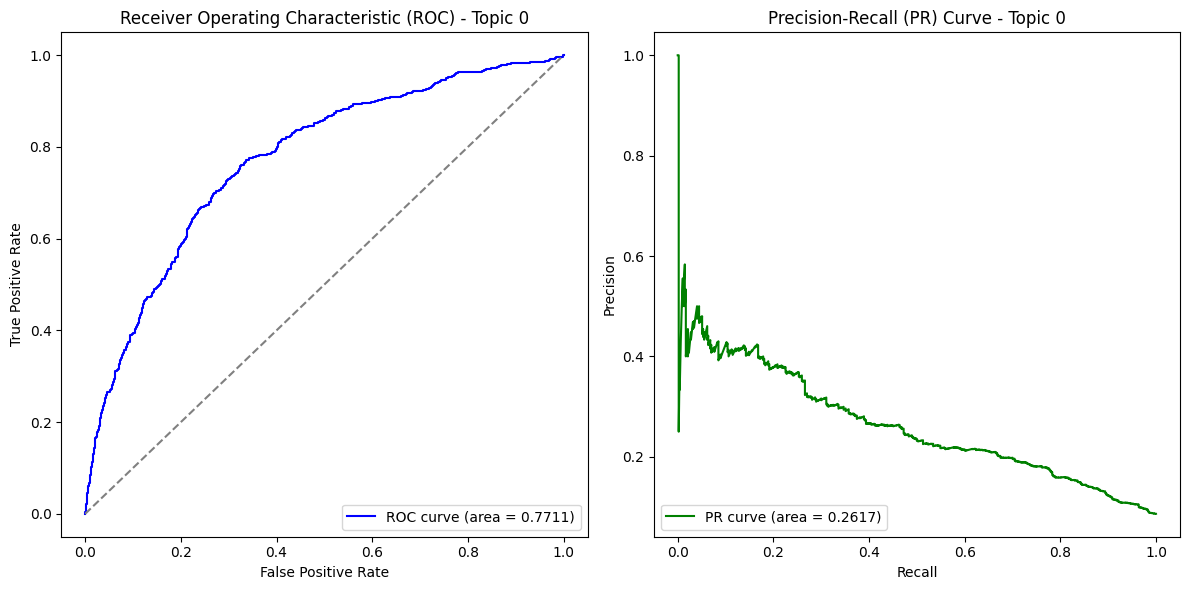

Evaluating topic 1
Topic 1 - auROC: 0.7842, auPR: 0.3309, F1: 0.2663


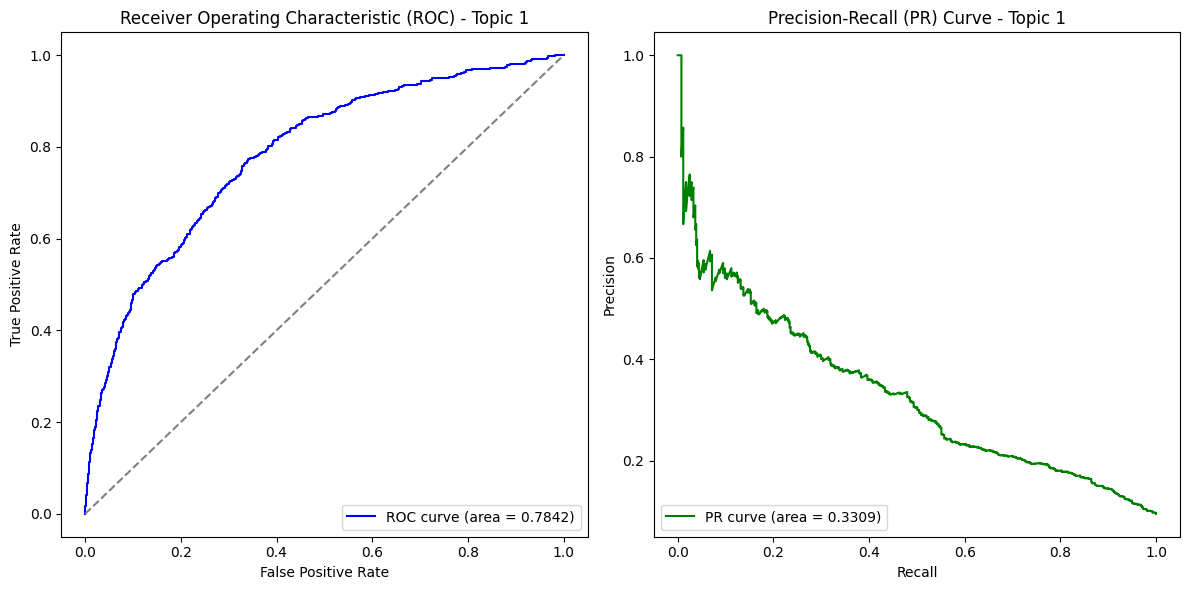

Evaluating topic 2
Topic 2 - auROC: 0.8374, auPR: 0.5079, F1: 0.4704


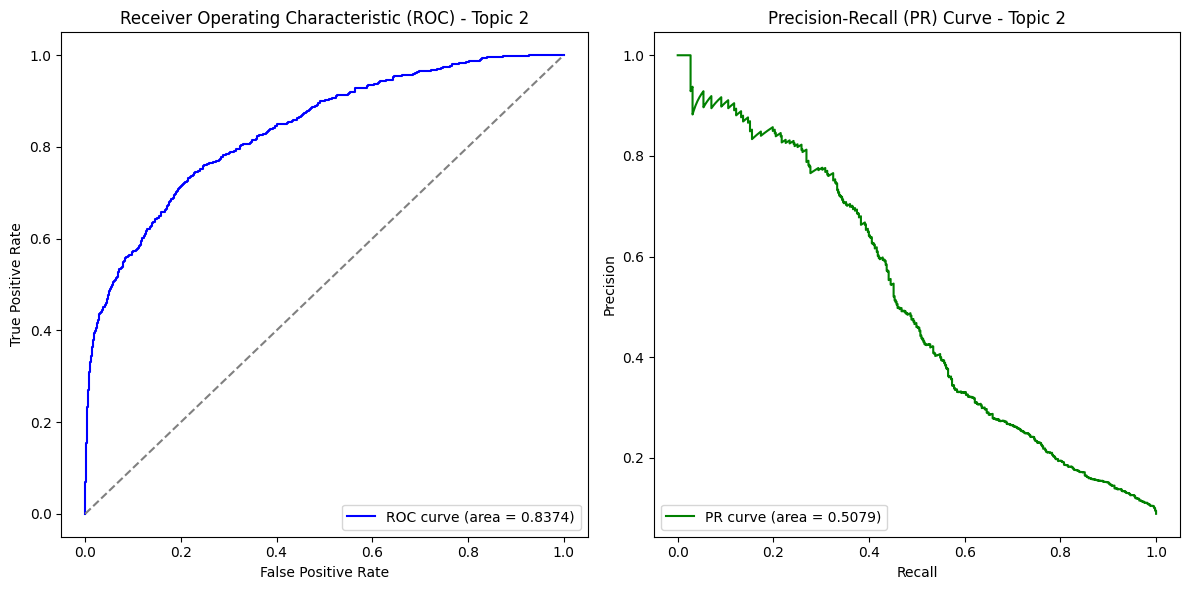

Evaluating topic 3
Topic 3 - auROC: 0.8322, auPR: 0.4116, F1: 0.3899


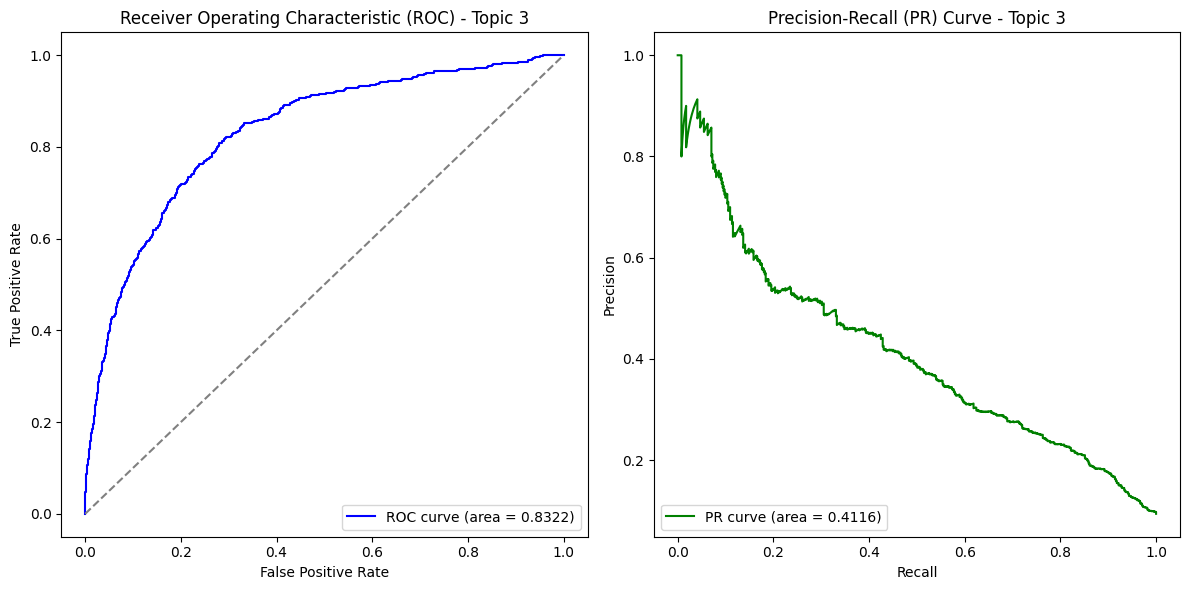

Evaluating topic 4
Topic 4 - auROC: 0.8392, auPR: 0.4799, F1: 0.3754


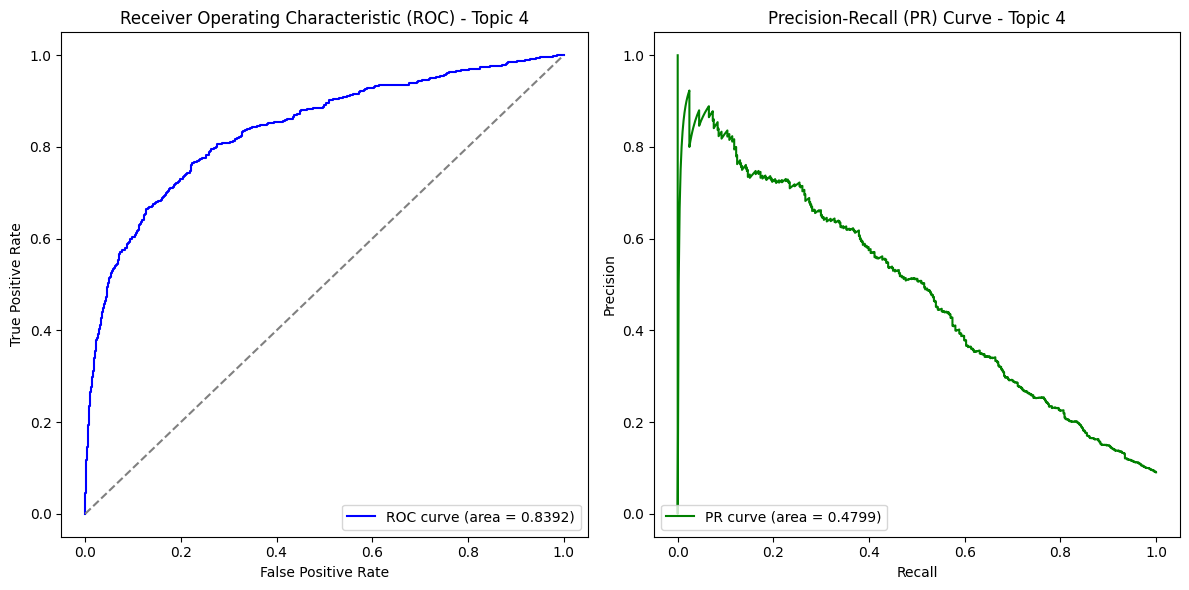

Evaluating topic 5
Topic 5 - auROC: 0.7634, auPR: 0.2414, F1: 0.1370


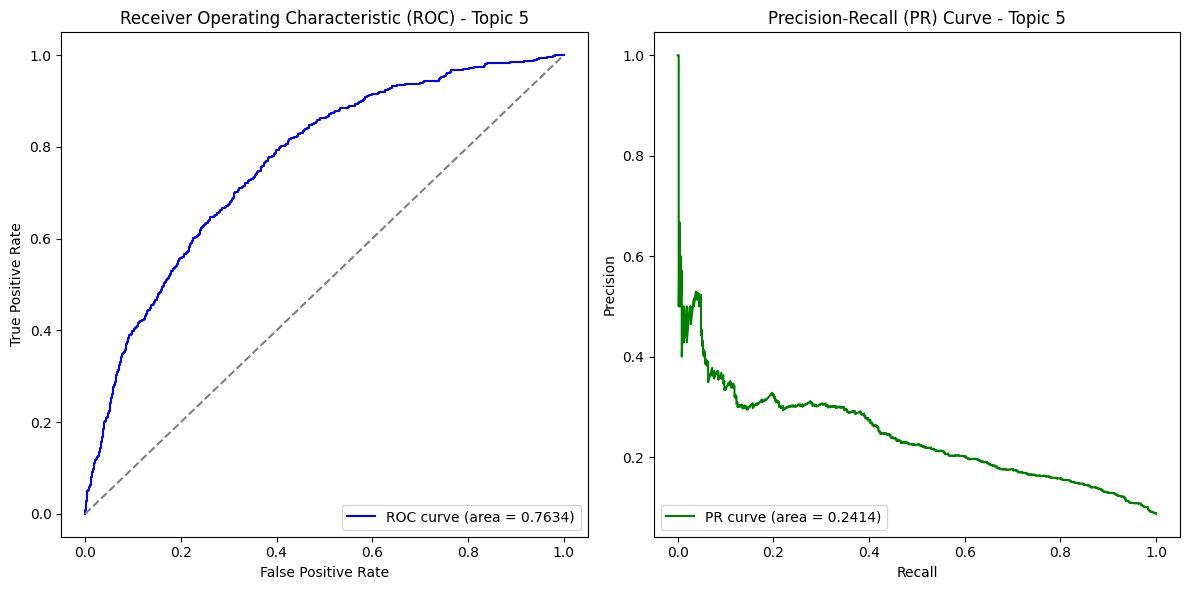

Evaluating topic 6
Topic 6 - auROC: 0.7727, auPR: 0.2737, F1: 0.2614


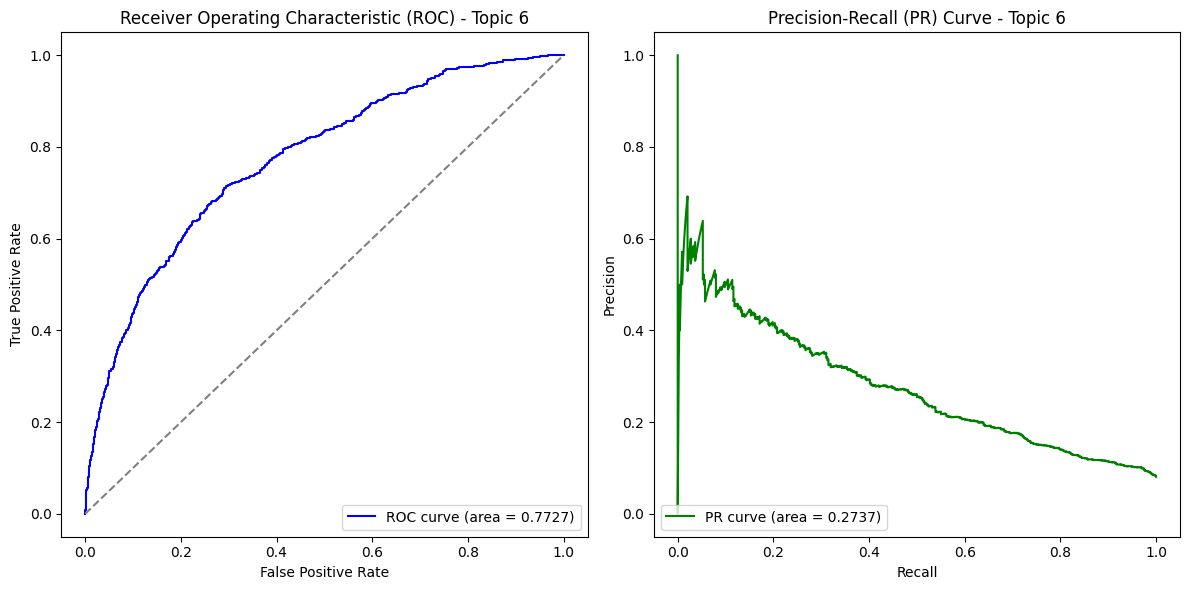

Evaluating topic 7
Topic 7 - auROC: 0.7738, auPR: 0.2891, F1: 0.2048


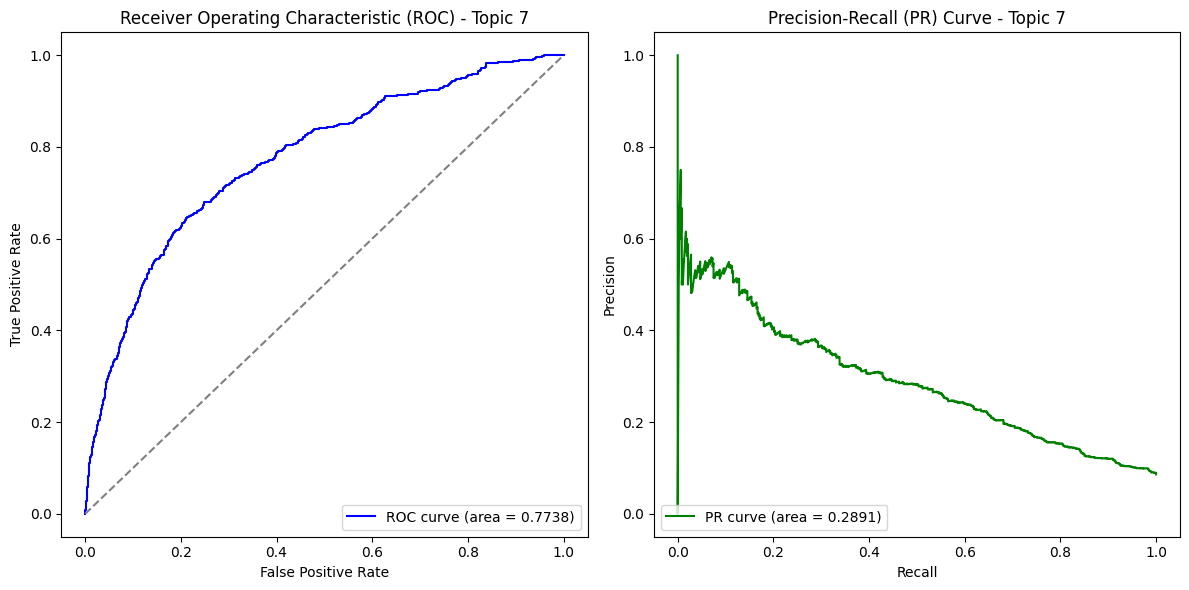

Evaluating topic 8
Topic 8 - auROC: 0.7199, auPR: 0.2039, F1: 0.0454


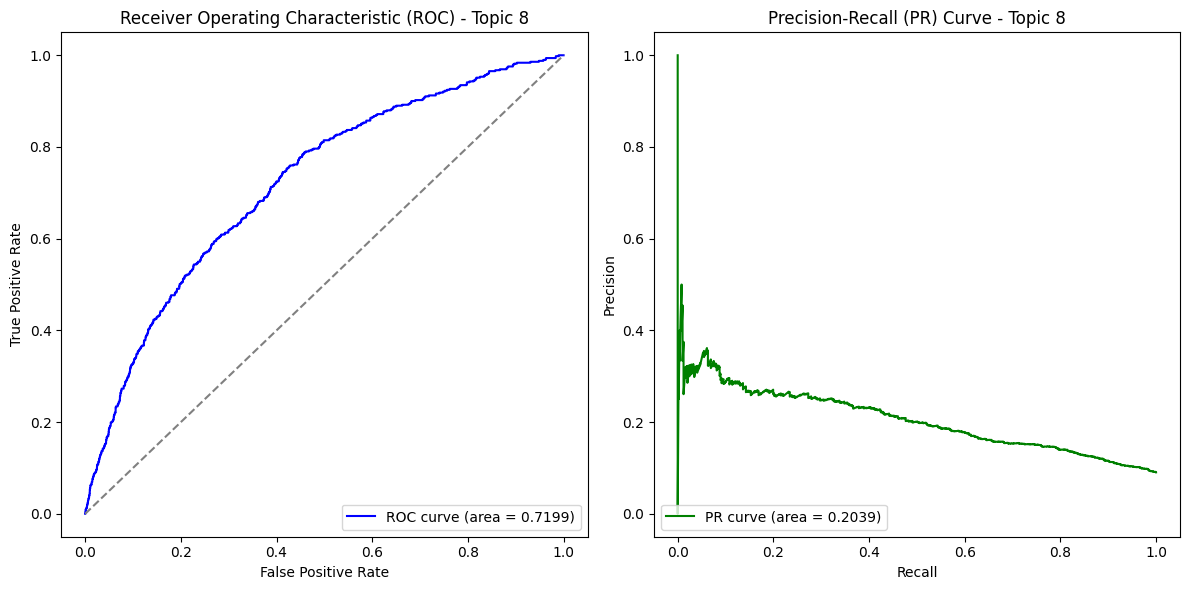

Evaluating topic 9
Topic 9 - auROC: 0.7628, auPR: 0.2381, F1: 0.1684


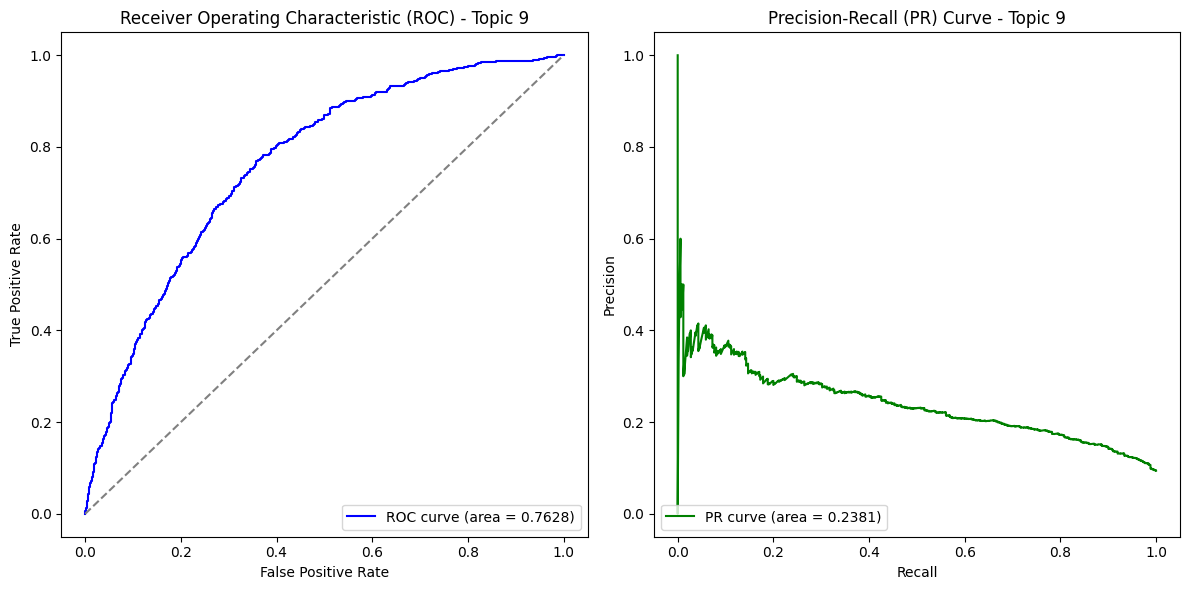

Evaluating topic 10
Topic 10 - auROC: 0.9136, auPR: 0.7288, F1: 0.6765


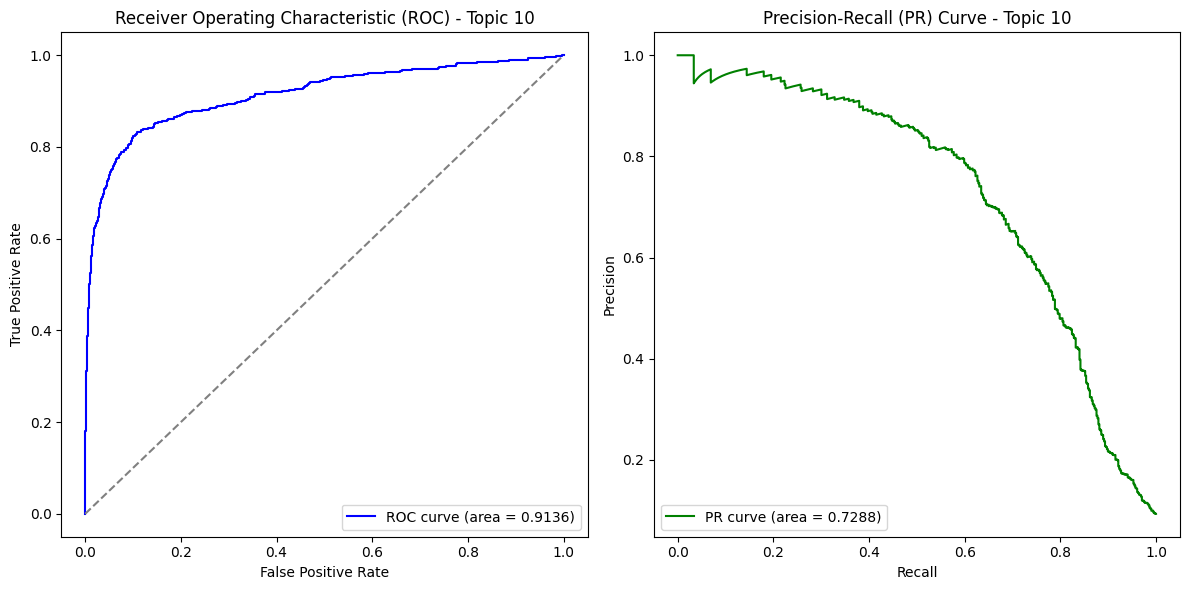

Evaluating topic 11
Topic 11 - auROC: 0.7874, auPR: 0.3905, F1: 0.3502


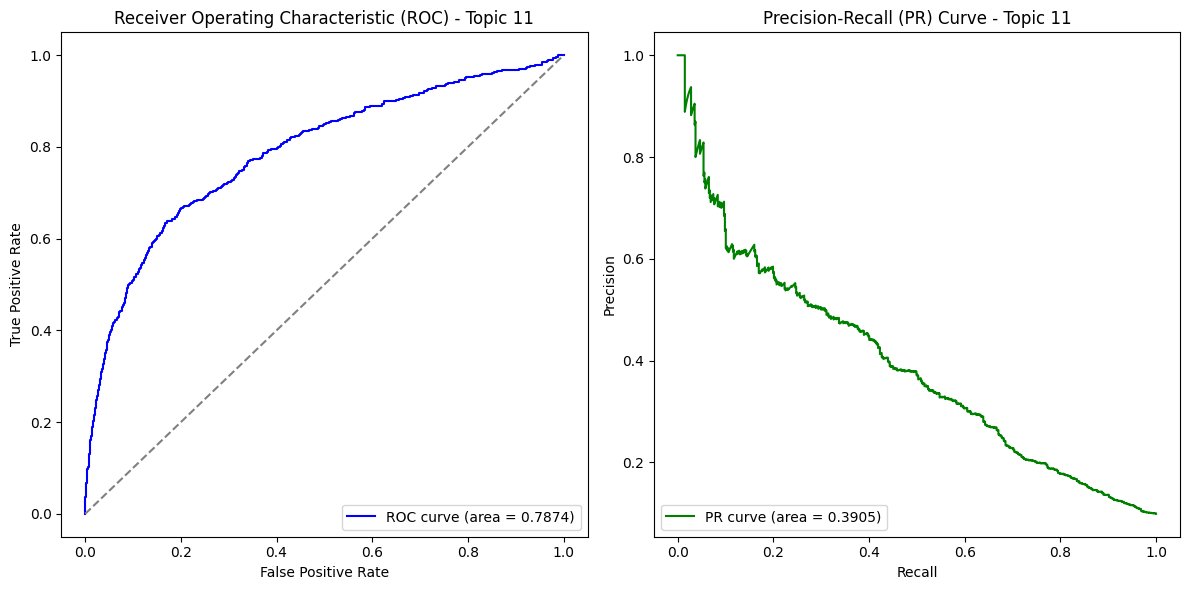

Evaluating topic 12
Topic 12 - auROC: 0.7239, auPR: 0.2234, F1: 0.1250


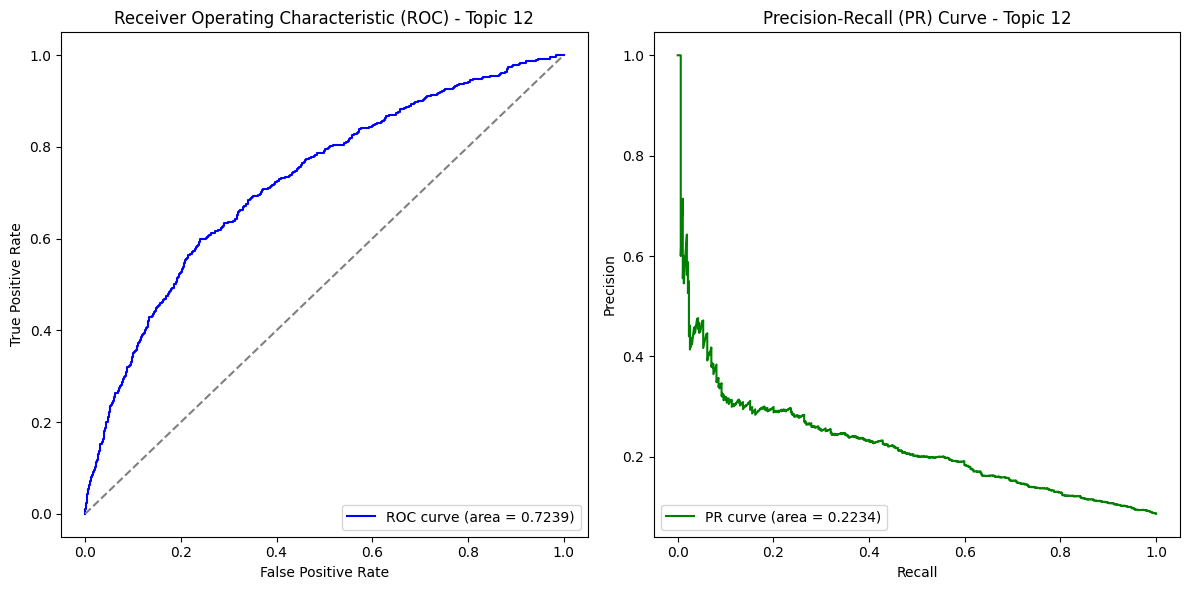

Evaluating topic 13
Topic 13 - auROC: 0.6979, auPR: 0.1962, F1: 0.0944


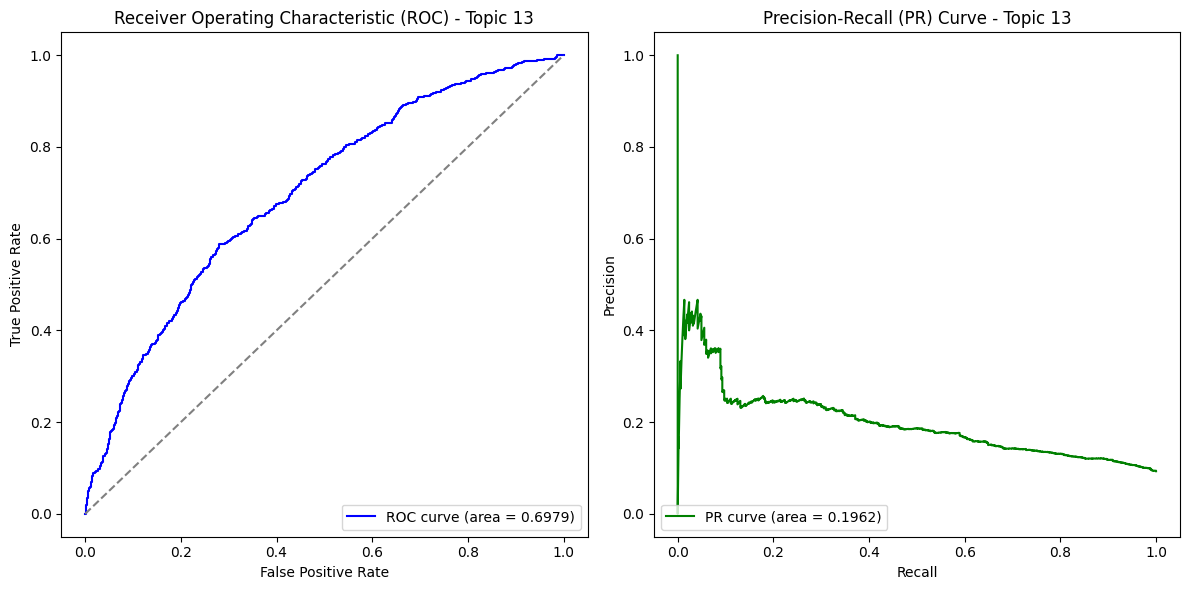

Evaluating topic 14
Topic 14 - auROC: 0.9226, auPR: 0.7004, F1: 0.6227


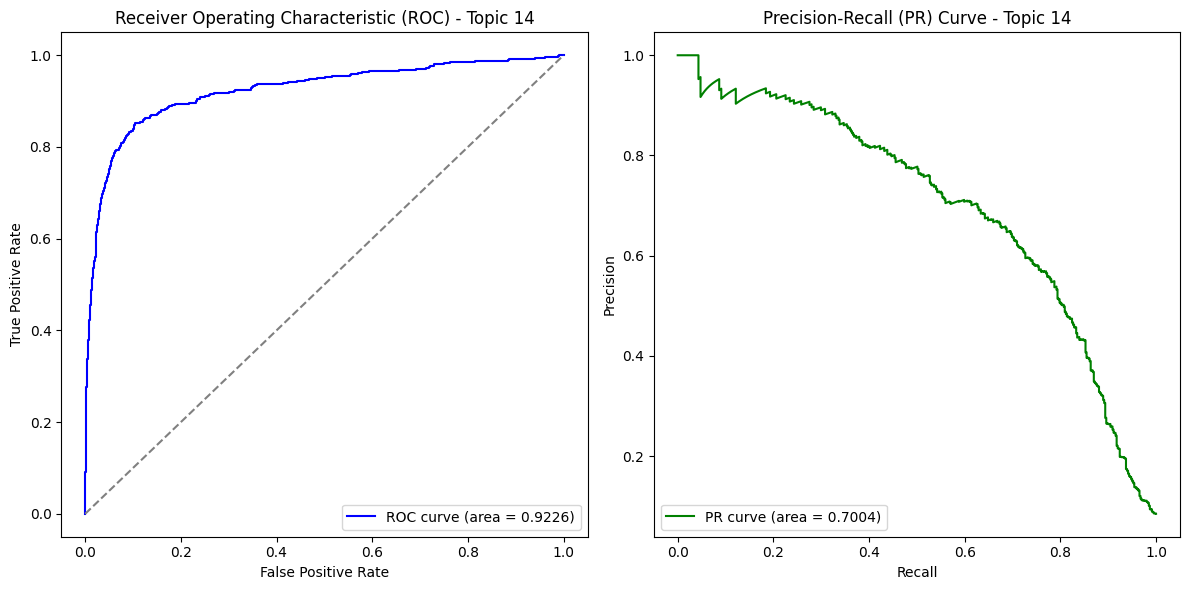

In [25]:
# Evaluate model performance for each topic
num_topics = y_test_np.shape[1]
auroc_values = []
aupr_values = []
f1_scores = []

print(f"\nEvaluating {num_topics} topics...")

for topic_idx in range(num_topics):
    print(f'Evaluating topic {topic_idx}')
    
    # Calculate ROC and PR metrics for the current topic
    fpr, tpr, _ = roc_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    roc_auc = auc(fpr, tpr)
    auroc_values.append(roc_auc)
    
    precision, recall, _ = precision_recall_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    pr_auc = auc(recall, precision)
    aupr_values.append(pr_auc)

    # Binarize predictions for F1 score calculation
    y_pred_bin = (y_pred_np[:, topic_idx] >= 0.5).astype(int)
    f1 = f1_score(y_test_np[:, topic_idx], y_pred_bin)
    f1_scores.append(f1)
    
    print(f'Topic {topic_idx} - auROC: {roc_auc:.4f}, auPR: {pr_auc:.4f}, F1: {f1:.4f}')
    
    # Plot ROC and PR curves for the current topic
    plt.figure(figsize=(12, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - Topic {topic_idx}')
    plt.legend(loc='lower right')
    
    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', label=f'PR curve (area = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall (PR) Curve - Topic {topic_idx}')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

In [26]:
# Summary statistics
print(f"\nSummary Statistics:")
print(f"Mean auROC: {np.mean(auroc_values):.4f} ± {np.std(auroc_values):.4f}")
print(f"Mean auPR: {np.mean(aupr_values):.4f} ± {np.std(aupr_values):.4f}")
print(f"Mean F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Exact Match Accuracy: {exact_acc:.4f}")
print(f"Hamming Accuracy: {hamming_acc:.4f}")


Summary Statistics:
Mean auROC: 0.7935 ± 0.0629
Mean auPR: 0.3652 ± 0.1659
Mean F1: 0.2957 ± 0.1802
Exact Match Accuracy: 0.0312
Hamming Accuracy: 0.9142


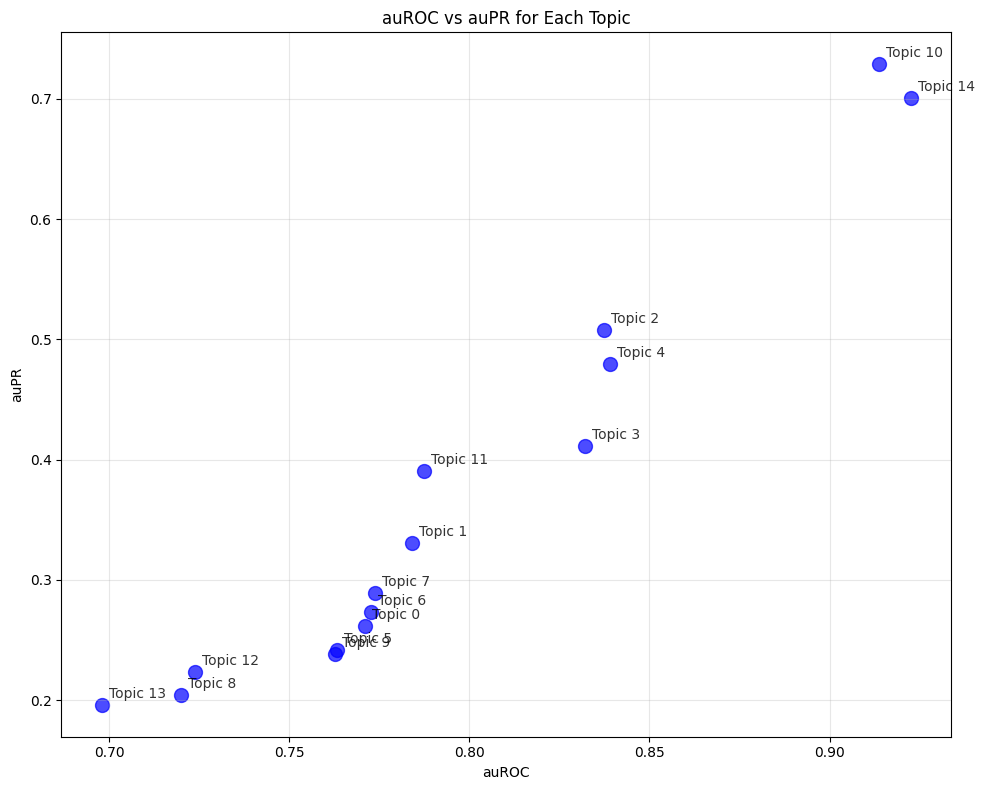

In [27]:
# Scatter plot of auROC vs auPR
plt.figure(figsize=(10, 8))
plt.scatter(auroc_values, aupr_values, color='blue', alpha=0.7, s=100, )
plt.xlabel('auROC')
plt.ylabel('auPR')
plt.title('auROC vs auPR for Each Topic')
plt.grid(True, alpha=0.3)

# Annotate each point with the topic index
for i, (x, y) in enumerate(zip(auroc_values, aupr_values)):
    plt.annotate(f'Topic {i}', (x, y), fontsize=10, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

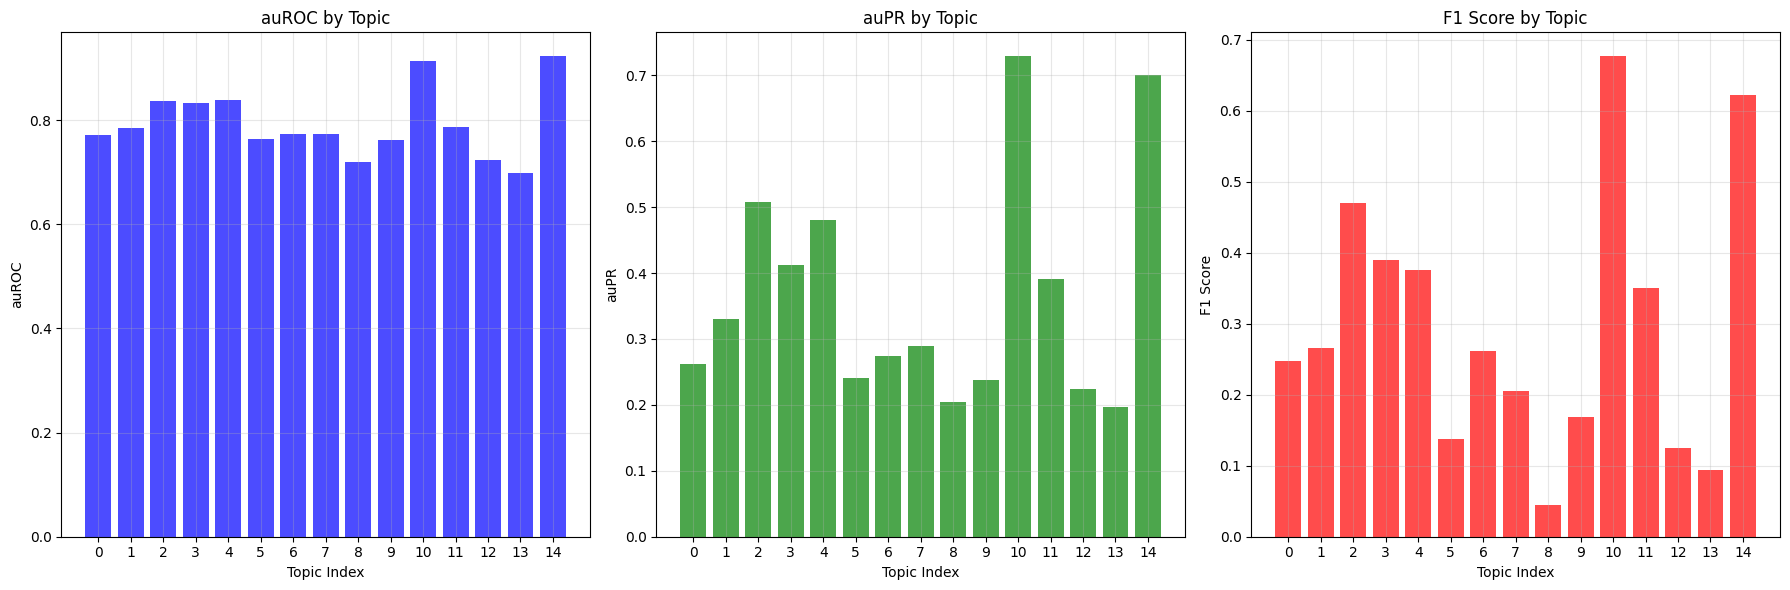

In [28]:
# Bar plots for metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# auROC bar plot
axes[0].bar(range(num_topics), auroc_values, color='blue', alpha=0.7)
axes[0].set_xlabel('Topic Index')
axes[0].set_ylabel('auROC')
axes[0].set_title('auROC by Topic')
axes[0].set_xticks(range(num_topics))
axes[0].grid(True, alpha=0.3)

# auPR bar plot
axes[1].bar(range(num_topics), aupr_values, color='green', alpha=0.7)
axes[1].set_xlabel('Topic Index')
axes[1].set_ylabel('auPR')
axes[1].set_title('auPR by Topic')
axes[1].set_xticks(range(num_topics))
axes[1].grid(True, alpha=0.3)

# F1 bar plot
axes[2].bar(range(num_topics), f1_scores, color='red', alpha=0.7)
axes[2].set_xlabel('Topic Index')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score by Topic')
axes[2].set_xticks(range(num_topics))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

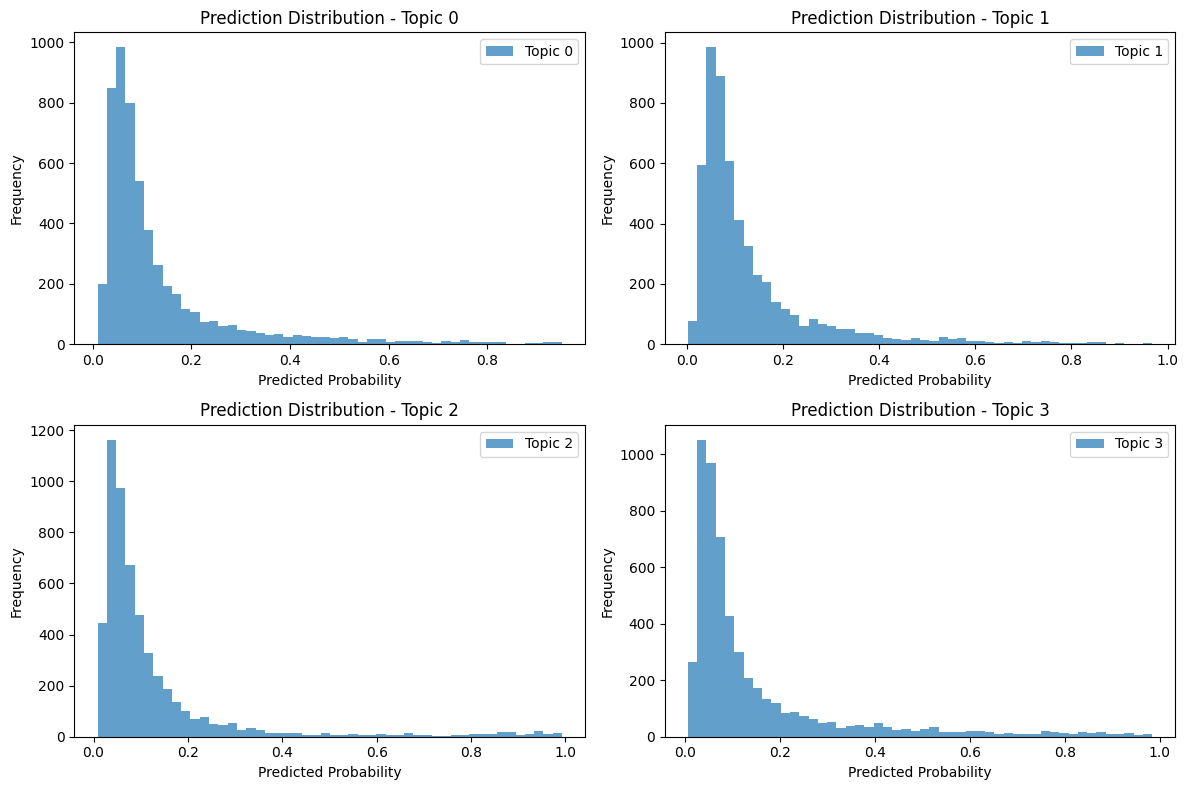


Sample predictions (first 10 samples):
Sample 0:
  Predicted: [0.07590767 0.15826318 0.23461734 0.09218499 0.08686774 0.24045132
 0.07632994 0.09941673 0.20976505 0.29959252 0.03779626 0.14765982
 0.15691496 0.43614334 0.04048506]
  Actual:    [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 1:
  Predicted: [0.07038115 0.04906171 0.05993429 0.42946678 0.36171377 0.08031024
 0.05474792 0.0474344  0.03910923 0.05580363 0.08881263 0.45229593
 0.04690829 0.1223544  0.05965909]
  Actual:    [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 2:
  Predicted: [0.04276752 0.09318978 0.59131444 0.09895231 0.03588441 0.07165079
 0.05059474 0.03371842 0.11418125 0.08738059 0.06327221 0.3953484
 0.07566503 0.06600254 0.09012458]
  Actual:    [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 3:
  Predicted: [0.06154092 0.10590732 0.10484453 0.12968229

In [29]:
# Additional analysis: Prediction distribution
plt.figure(figsize=(12, 8))

# Histogram of predictions for each topic
for i in range(min(4, num_topics)):  # Show first 4 topics
    plt.subplot(2, 2, i+1)
    plt.hist(y_pred_np[:, i], bins=50, alpha=0.7, label=f'Topic {i}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Distribution - Topic {i}')
    plt.legend()

plt.tight_layout()
plt.show()

# Sample predictions vs targets
print("\nSample predictions (first 10 samples):")
for i in range(min(10, y_pred_np.shape[0])):
    print(f"Sample {i}:")
    print(f"  Predicted: {y_pred_np[i]}")
    print(f"  Actual:    {y_test_np[i]}")
    print(f"  Binary:    {(y_pred_np[i] > 0.5).astype(int)}")
    print()